# Post-Processing Statistical Models in Chapter 6

This notebook processes the brms/stan output and creates the figures used in this chapter. Generally, everything is pretty similar to the previous results. However, the estimation did change a little bit. The quadratic specification made some of my code break. I ended up changing things to a multilevel model. Throughout the analysis:

* I estimated a latent variable of authoritarianism. It doesn't matter, but for consistency with Stanley's latent variable analysis, it seemed wise.
* Multilevel model with random intercepts, authoritarianism, and authoritarianism-squared.
* Logit models for voting, multinomial for PID, linear for affective polarization
* Estimated everything in a bayesian framework. As you you'll see -- BRMS + tidybayes makes life pretty simple.




## Outline 

Here are the notes from Chris F's outline:

* Revised version of the old Chapter 5 on sorting among Whites (time series). noted in the revised introductory chapters, more emphasis will be placed on the discontinuous nature of sorting over time (dependent on the nature of elite partisan conflict at any given time).

* A basic aim will be to make the basic time-series results less of the overall chapter in order to differentiate our work from H&W. We will better situate / justify a longer time series analysis of sorting and polarization: party id, affect, voting. H&W only went up to 2004; need to see whether trend has continued or was specific to that era of ‘moral polarization.’ (Moral polarization dropped post-2000.) Moreover, we seek to determine whether Trump produced a bump in 2016 and 2020. In general, make the long-term sorting result a smaller part of the story.

I. Basic time series analyses, 1992-2020. Voting, candidate and party FTs, and PID. The joyplots can accompany the portion on PID. 

II. 	Mediation analyses. Do for two dependent variables, with PID as the mediator: (a) vote and (b) candidate FTs.

III. 	Who is sorting: authoritarianism x education interactions. We can do two things with this. First, we show that the educated are generally more sorted, consistent with general expectations about who attends to differences between the parties. Second, we show that the moderating effect of education has nevertheless decreased.  We will do this for several outcomes: (a) vote, (b) candidate and party FTs, and (c) PID. 


In [1]:
### Load dependencies, data, themes, configurations
rm(list = ls())
library(brms)
library(tidyverse)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
## Some helper functions, and configurations.
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/configurations.r")
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/user_functions.r")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/clean_data/pooled.auth.rda")  ### Just work from this data; everything should be here, recoded.
## models
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/vote_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/party_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/affect.rda")


ggtheme = theme(
        plot.title=element_text(face="bold",hjust=0,vjust=0,colour="#3C3C3C",size=20),
        axis.text.x=element_text(size=16,colour="#535353",face="bold"),
        axis.text.y=element_text(size=16,colour="#535353",face="bold"),
        axis.title = element_text(size=16,colour="#535353",face="bold"),
        axis.title.y=element_text(size=16,colour="#535353",face="bold",vjust=1.5),
        axis.ticks=element_blank(),
        strip.text.x = element_text(size = 16),
        panel.grid.major=element_line(colour="#D0D0D0",size=.25),
        panel.background=element_rect(fill="white"),
        legend.text=element_text(size=14),
        legend.title=element_text(size=16)) 
####

Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.0.5"
Loading 'brms' package (version 2.14.4). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'tidybayes'


The following objects are masked from 'package:brms':

    dstudent_t, pstudent_t, qstudent_t, rstudent_t



Attaching package: 'boot'


The following object is masked from 'package:msm':

    cav




# Predicted Values, Voting (1992 - 2020)

The first part of the chapter shows the total effect of authoritarianism on voting. I estimated these models in the "model" notebook. Some models do take a bit, so I ran everything, then processed the results. As you'll see all models can be passed to $\texttt{tidybayes}$ to produce figures. 

Here's the linear model:

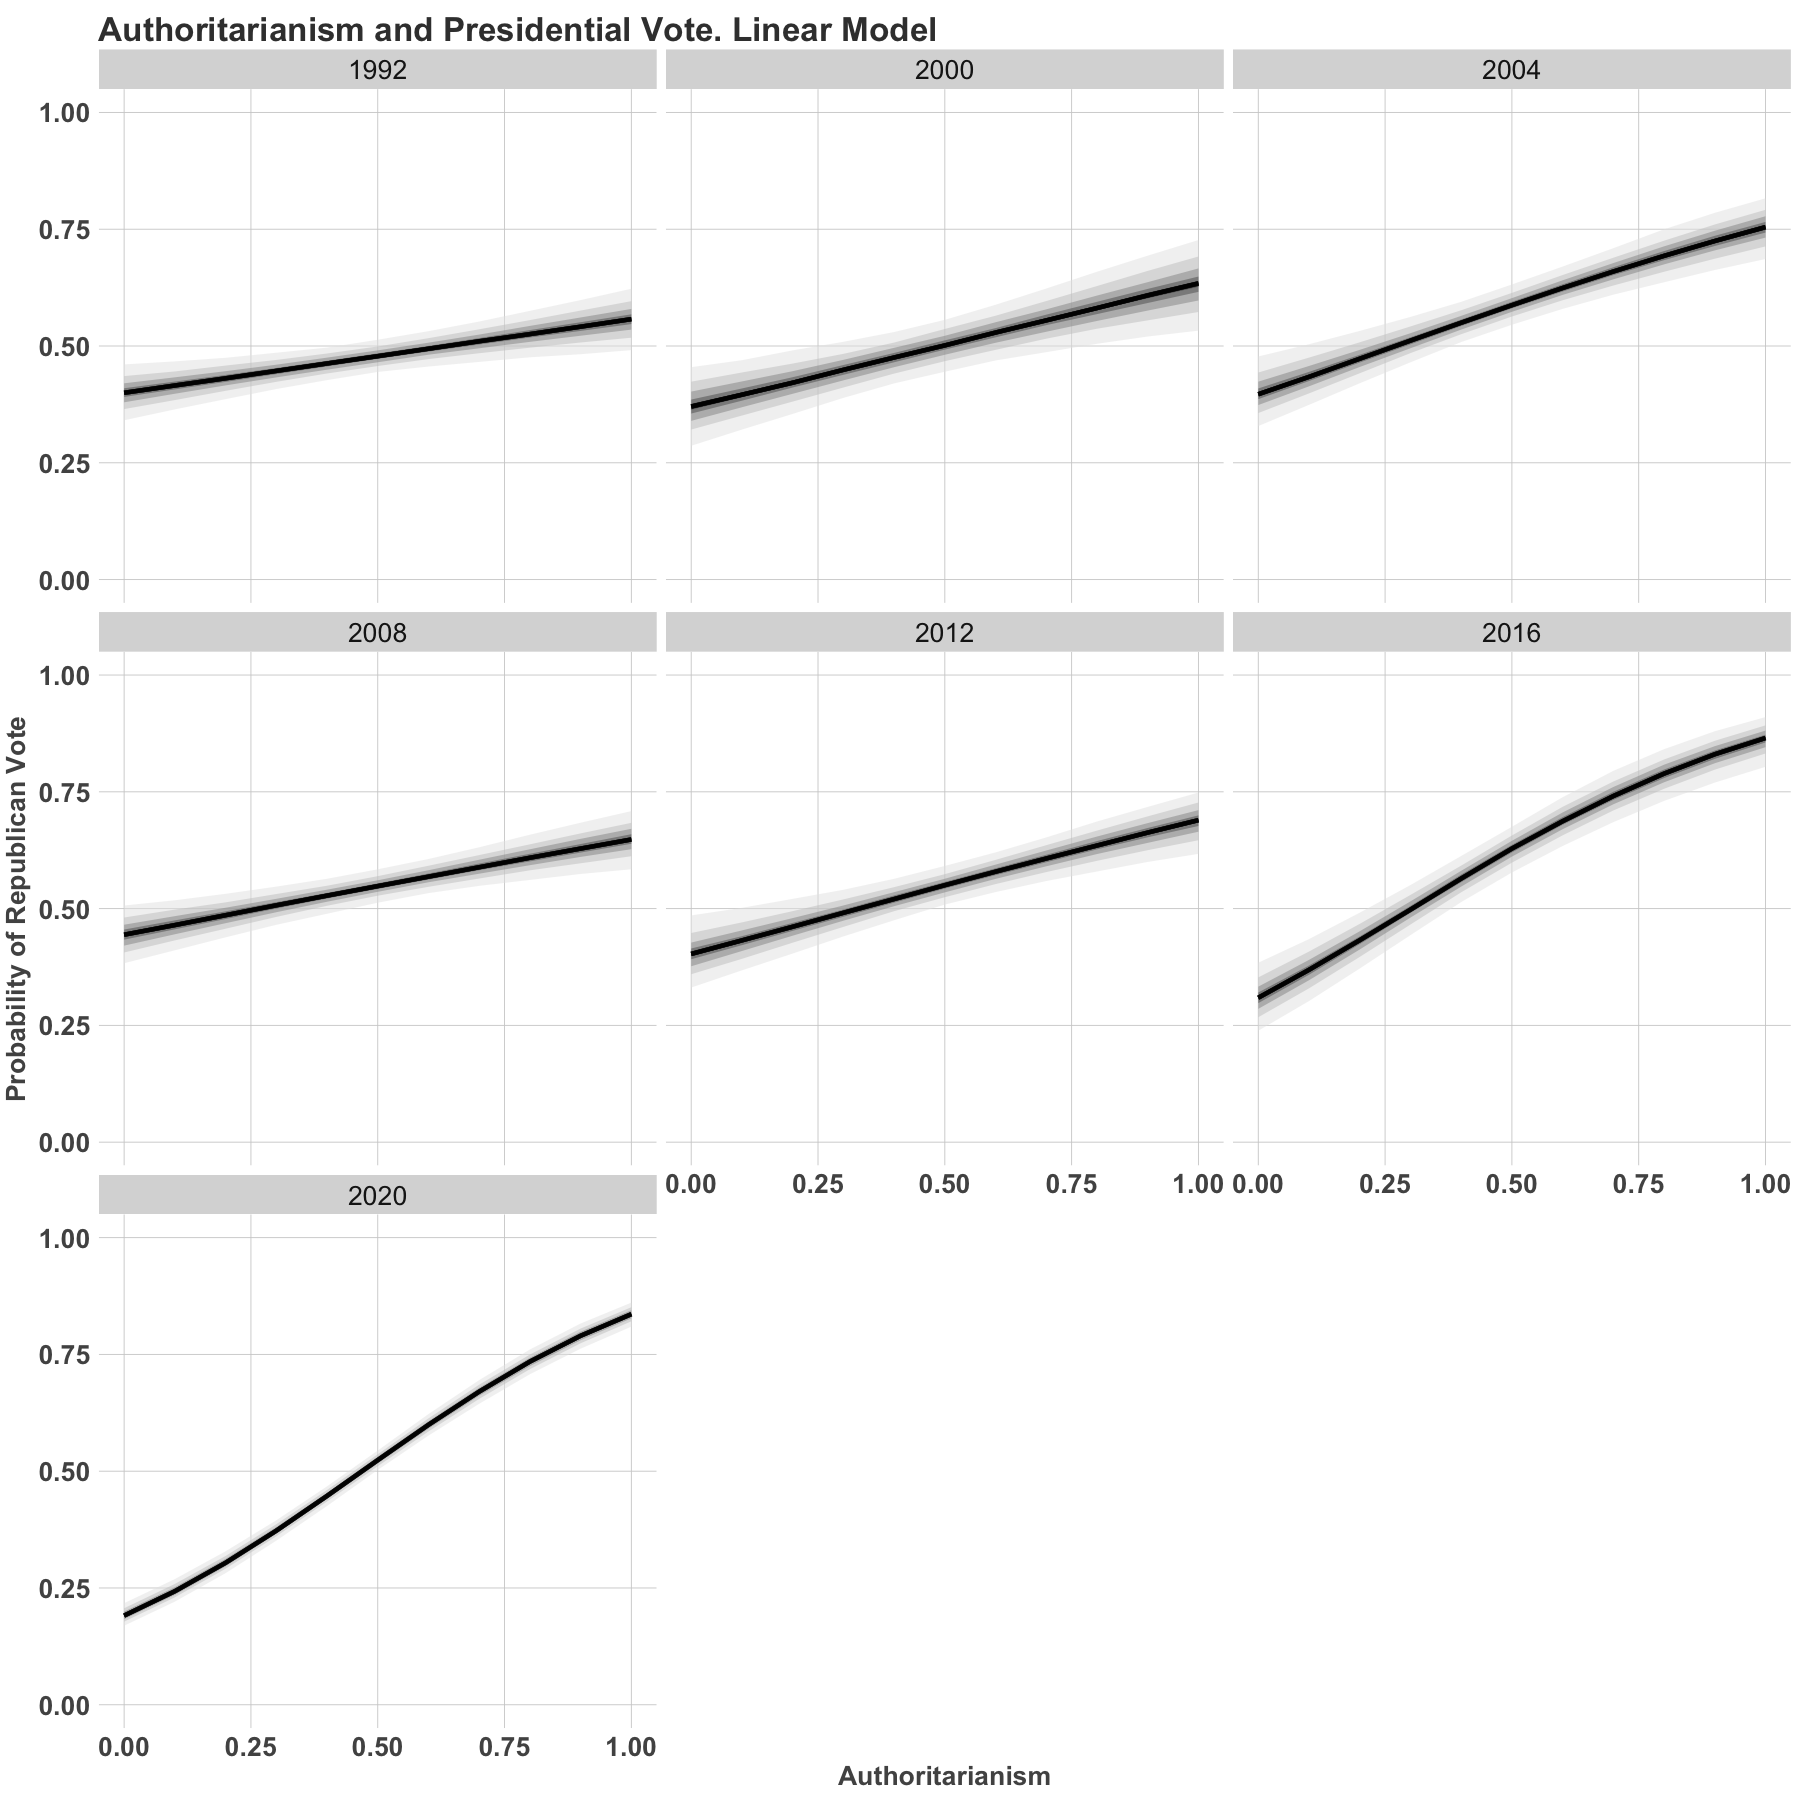

In [2]:
library(simplecolors)
## Pull out the relevant models from my output.
fit0b = vote_models[[2]] # Random intercept model saved from models
fit1  = vote_models[[3]] # Random slope mode saved fro model, linear

## Expand the data used to estimate this model
fixed_data = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), authoritarianism = seq_range(authoritarianism, n = 11))  %>% 
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)
                                                      
          
m0 = fixed_data %>% add_linpred_draws(fit0b) %>%  mutate(Vote_Republican = plogis(.linpred))  ## Expand posterior

options(repr.plot.width=15, repr.plot.height=15)

## Plot linear Effects
 m0 %>% ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
       scale_fill_manual(values = sc_grey(light = 1:5))+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") %>% suppressWarnings()
  


Here's the quadratic specification. This should serve as **Figure 1** in Chapter 6.

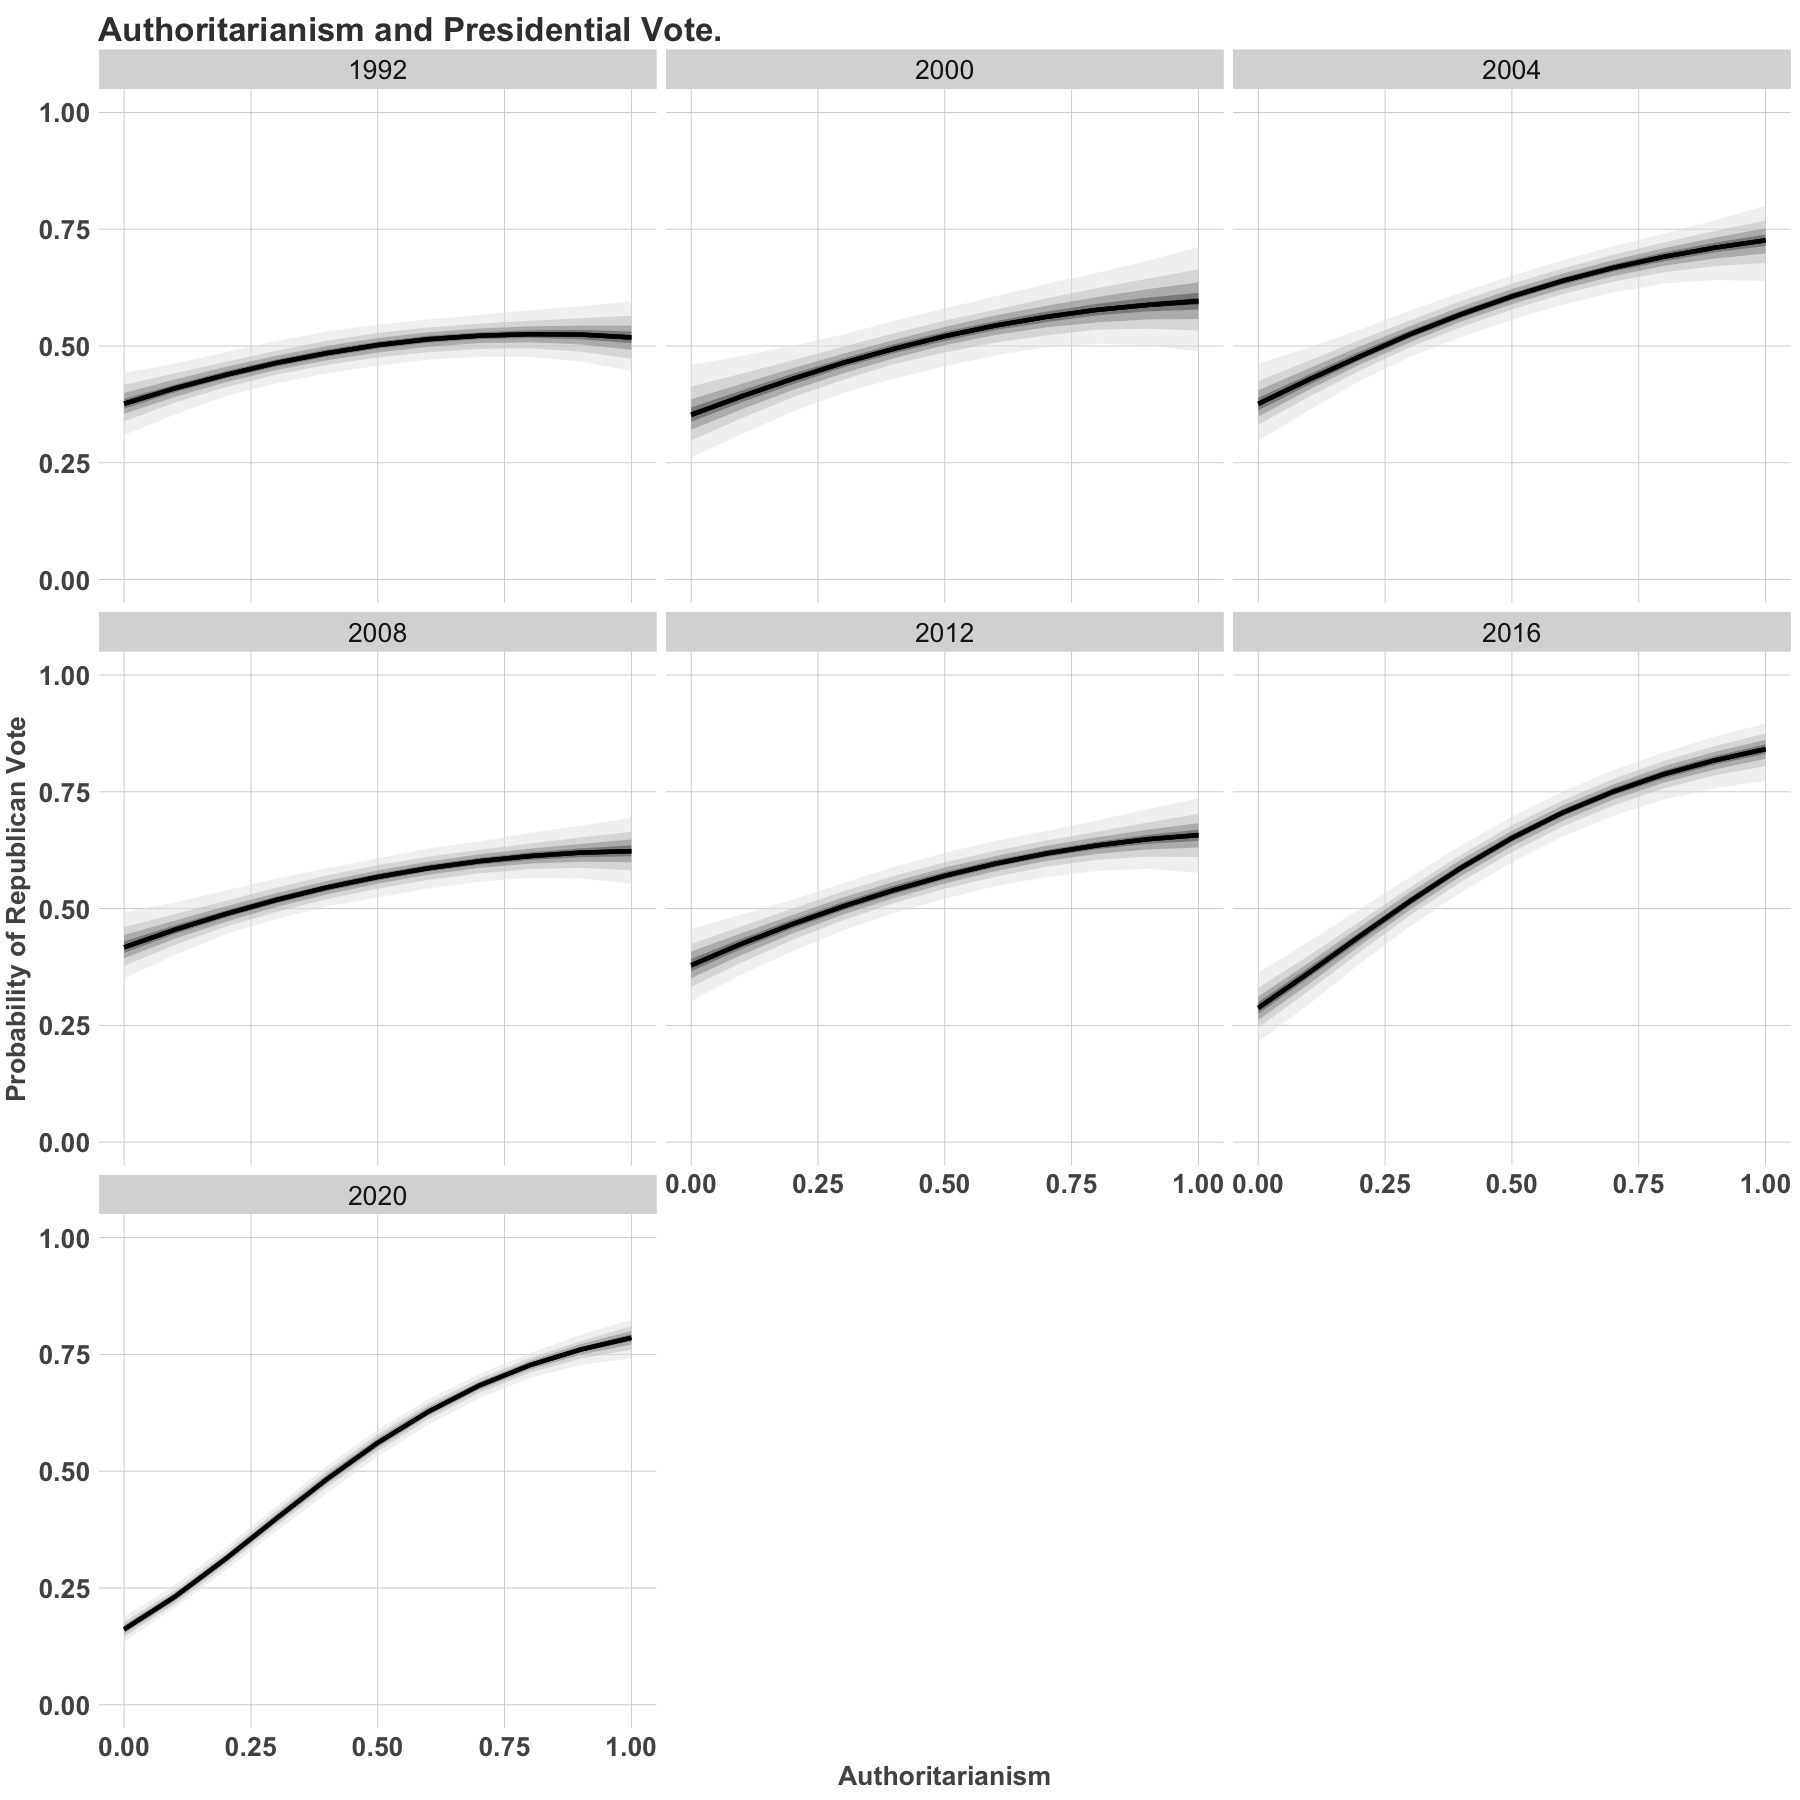

In [3]:
m1 = fixed_data %>% add_linpred_draws(fit1) %>%  mutate(Vote_Republican = plogis(.linpred))  ## Expand posterior

options(repr.plot.width=15, repr.plot.height=15)

## Plot linear Effects
 m1 %>% ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
       scale_fill_manual(values = sc_grey(light = 1:5))+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote.") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  


# Cross Validation

What model provides a better fit? A useful way to get at this -- due in part to the non-nested nature of the models -- is "leave-one-out" validation. Basically estimate the model on some subset of the data, predict the model on the "hold-out" data, and compare.  

In [11]:
# Generate an expanded dataset varying levels of authoritarianism at fixed covariates.
### linear model (fit0b) ###
fit0a = vote_models[[1]]
fit0b = vote_models[[2]]
fit1  = vote_models[[3]]

loo(fit0a, fit0b, fit1)

Output of model 'fit0a':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3754.5 26.8
p_loo        14.8  0.2
looic      7509.0 53.5
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit0b':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3685.1 28.7
p_loo        20.2  0.3
looic      7370.1 57.3
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit1':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3676.8 28.9
p_loo        22.9  0.4
looic      7353.6 57.8
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Model comparisons:
      elpd_diff se_diff
fit1    0.0       0.0  
fit0b  -8.2       4.3  
fit0a -77.

The quadratic model is a reasonably good improvement over the lienar model (fit0b) and substantially better than the random-intercept, authoritarianism-has-a-fixed-effect model (fit0a).

# Marginal Effects

Below are the marginal effects. I'll show the linear effects, but throughout the remaining analysis, I just present the quadratic. As you can see here, there really isn't a large difference

### The Linear Variable Model

In [4]:
library(dplyr)
### Model to estimate AME
expanded_dat_0 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals

Adding missing grouping variables: `year`, `female`, `age`, `college`, `income`, `catholic`, `jewish`, `other`, `authoritarianism`, `authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.04792691,0.1491353,0.2505729
2000,0.09380816,0.2502157,0.3899729
2004,0.22050578,0.3406553,0.4468286
2008,0.09130826,0.1951500,0.2870187
2012,0.15410865,0.2729135,0.3779595
2016,0.42140336,0.5327983,0.6346207
2020,0.57623964,0.6217558,0.6635904


### The Quadratic Variable Specification

In [5]:
### Model to estimate AME
expanded_dat_0 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals_q = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals_q

Adding missing grouping variables: `year`, `female`, `age`, `college`, `income`, `catholic`, `jewish`, `other`, `authoritarianism`, `authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.03533232,0.1329992,0.2328557
2000,0.07749971,0.2299629,0.3801666
2004,0.20974759,0.3329866,0.4377701
2008,0.09506544,0.1957390,0.2891884
2012,0.14733244,0.2653167,0.3788416
2016,0.42161527,0.5299153,0.6274290
2020,0.55654079,0.6021737,0.6460856


Here are the marginal effects in plot format. This should form **Figure 2**.

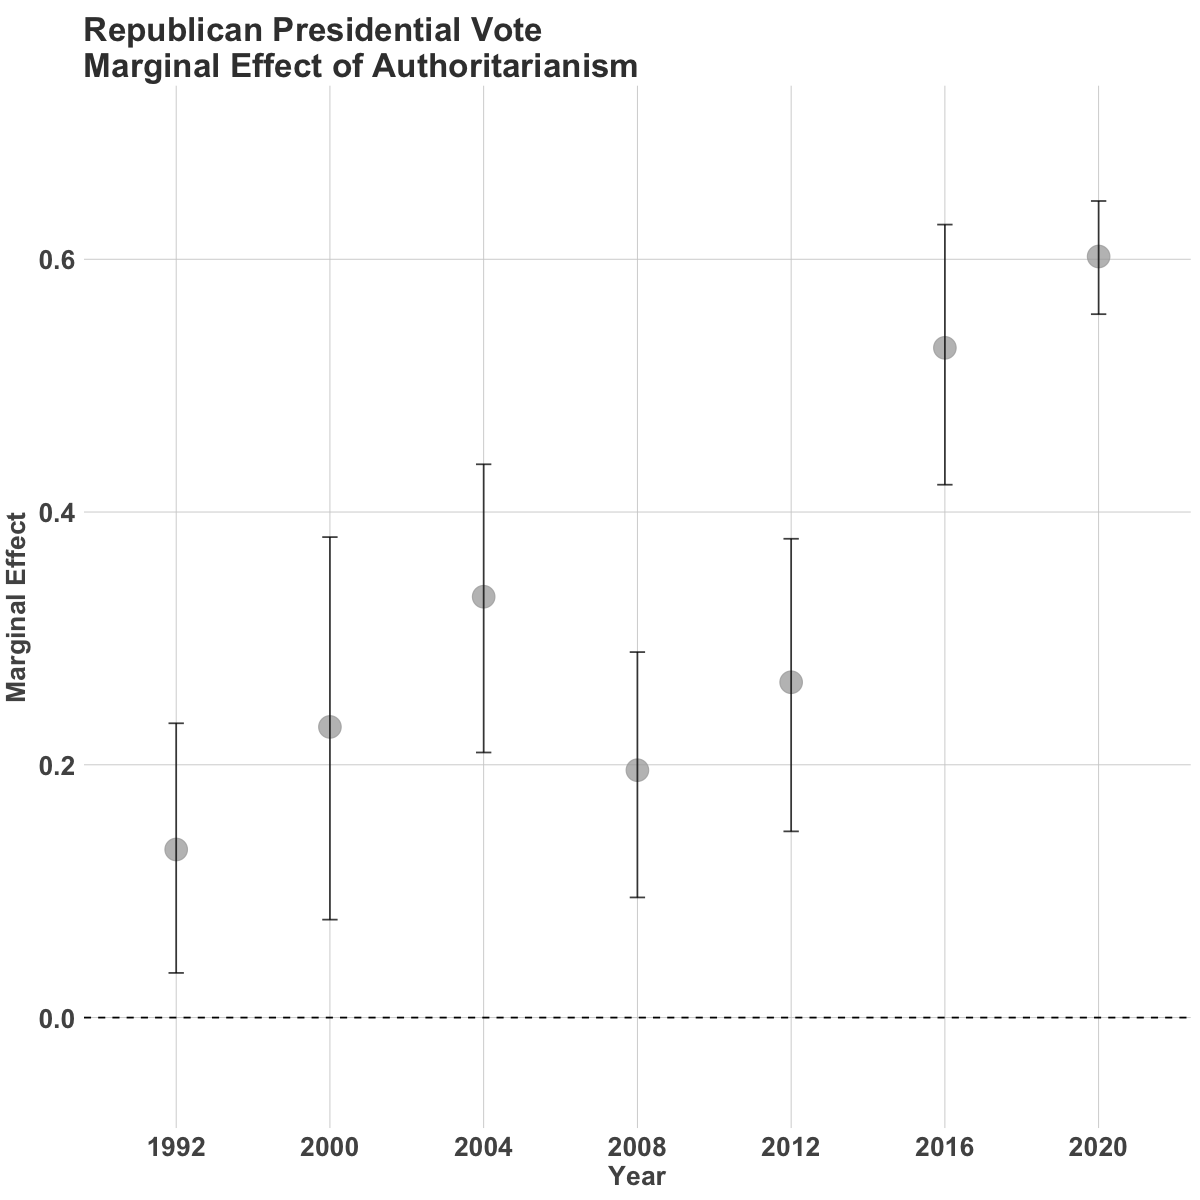

In [10]:
## Marginal Efffects plot for quadratic
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data = marginals_q,
              aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min))+
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Republican Presidential Vote\nMarginal Effect of Authoritarianism") +
  ggtheme + 
  scale_y_continuous("Marginal Effect", limits=c(-.05,0.70))+
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") 

This figure forms Figure 2 in the chapter.

## Education x Authoritarianism 

Here are the effects disaggregated by education. Some of it is new, and I think the marginal effect plot is particularly useful. I'm not sure where to present this -- I think the predictive plots make more sense for the concluding part of this chapter. Maybe we put this plot in an appendix.

In [11]:
## Marginal Effects Function -- adapt to more complicated interactions
library(dplyr)
fixed = data[,c("vote", "authoritarianism", 
            "female", "age", "college", "income",
            "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
              mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
              na.omit()
marginal_by_ed = function(fixed = fixed, model_fit = education){
                        out1 = fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1) , income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = quantile(authoritarianism, 0.025)) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        out2 =  fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = quantile(authoritarianism,.975)) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        r = fixed %>% na.omit() %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  
                                                                                                            authoritarianism = quantile(authoritarianism, 0.025))%>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) 
                        r$marginal = out2$.epred - out1$.epred 
                        return(r)
                        }


`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.


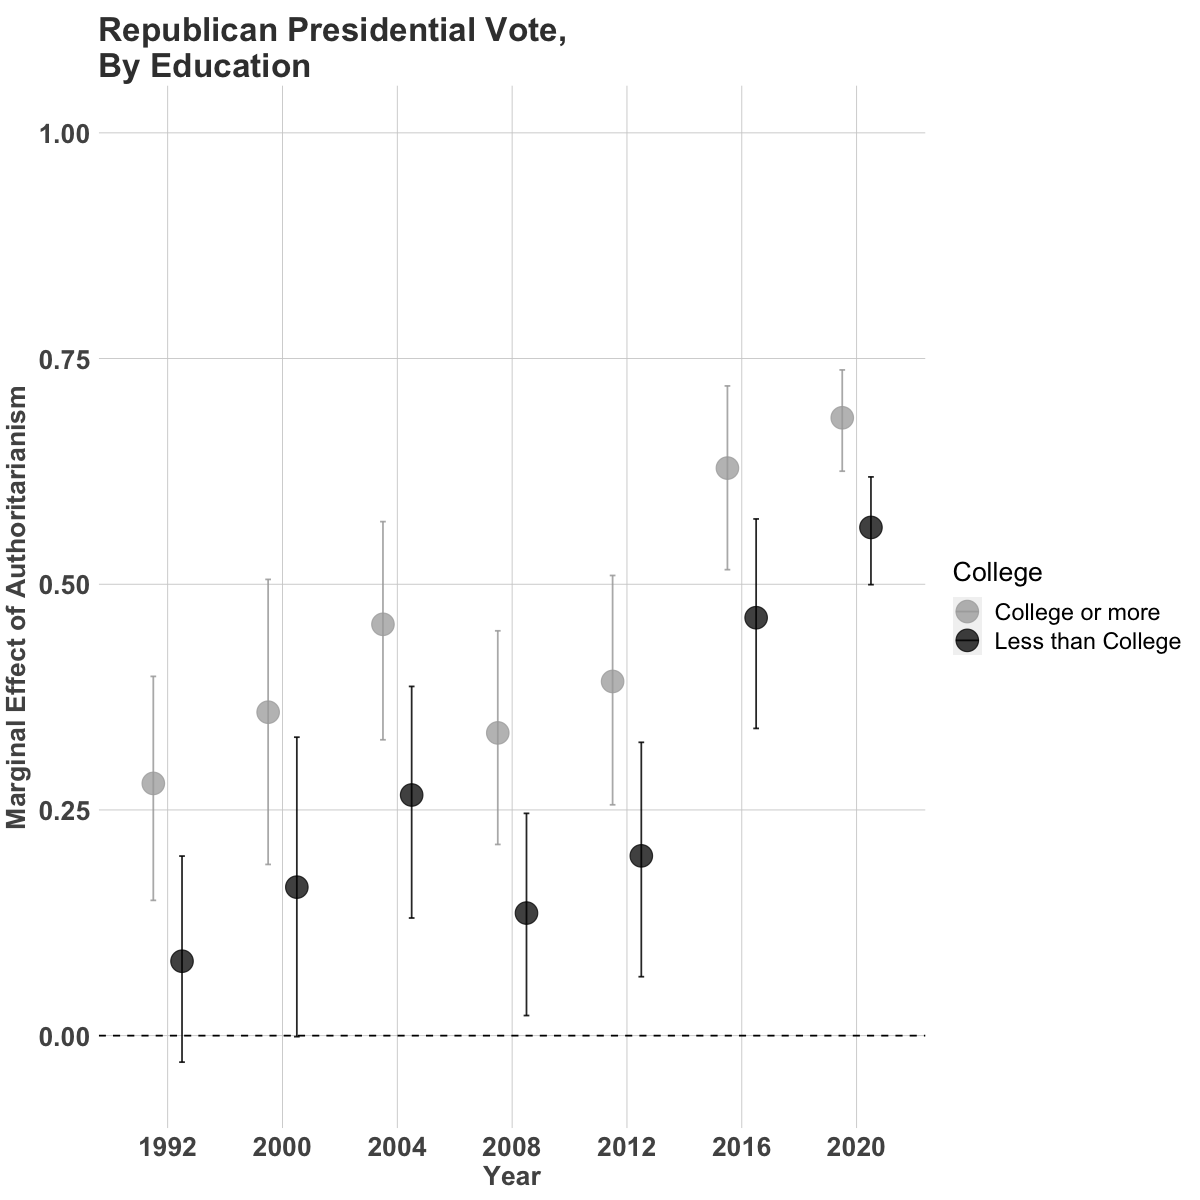

In [13]:
options(repr.plot.width=10, repr.plot.height=10)

education  = vote_models[[4]]

marginal_by_ed(fixed = fixed)  %>% mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>% group_by(year, Education) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(Education), group = as.factor(Education)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Republican Presidential Vote,\nBy Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.05,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

Here is the predictive plot. I think it's a bit more forceful. The slope is noticeably flatter for the less-educated, particularly pre 2016.

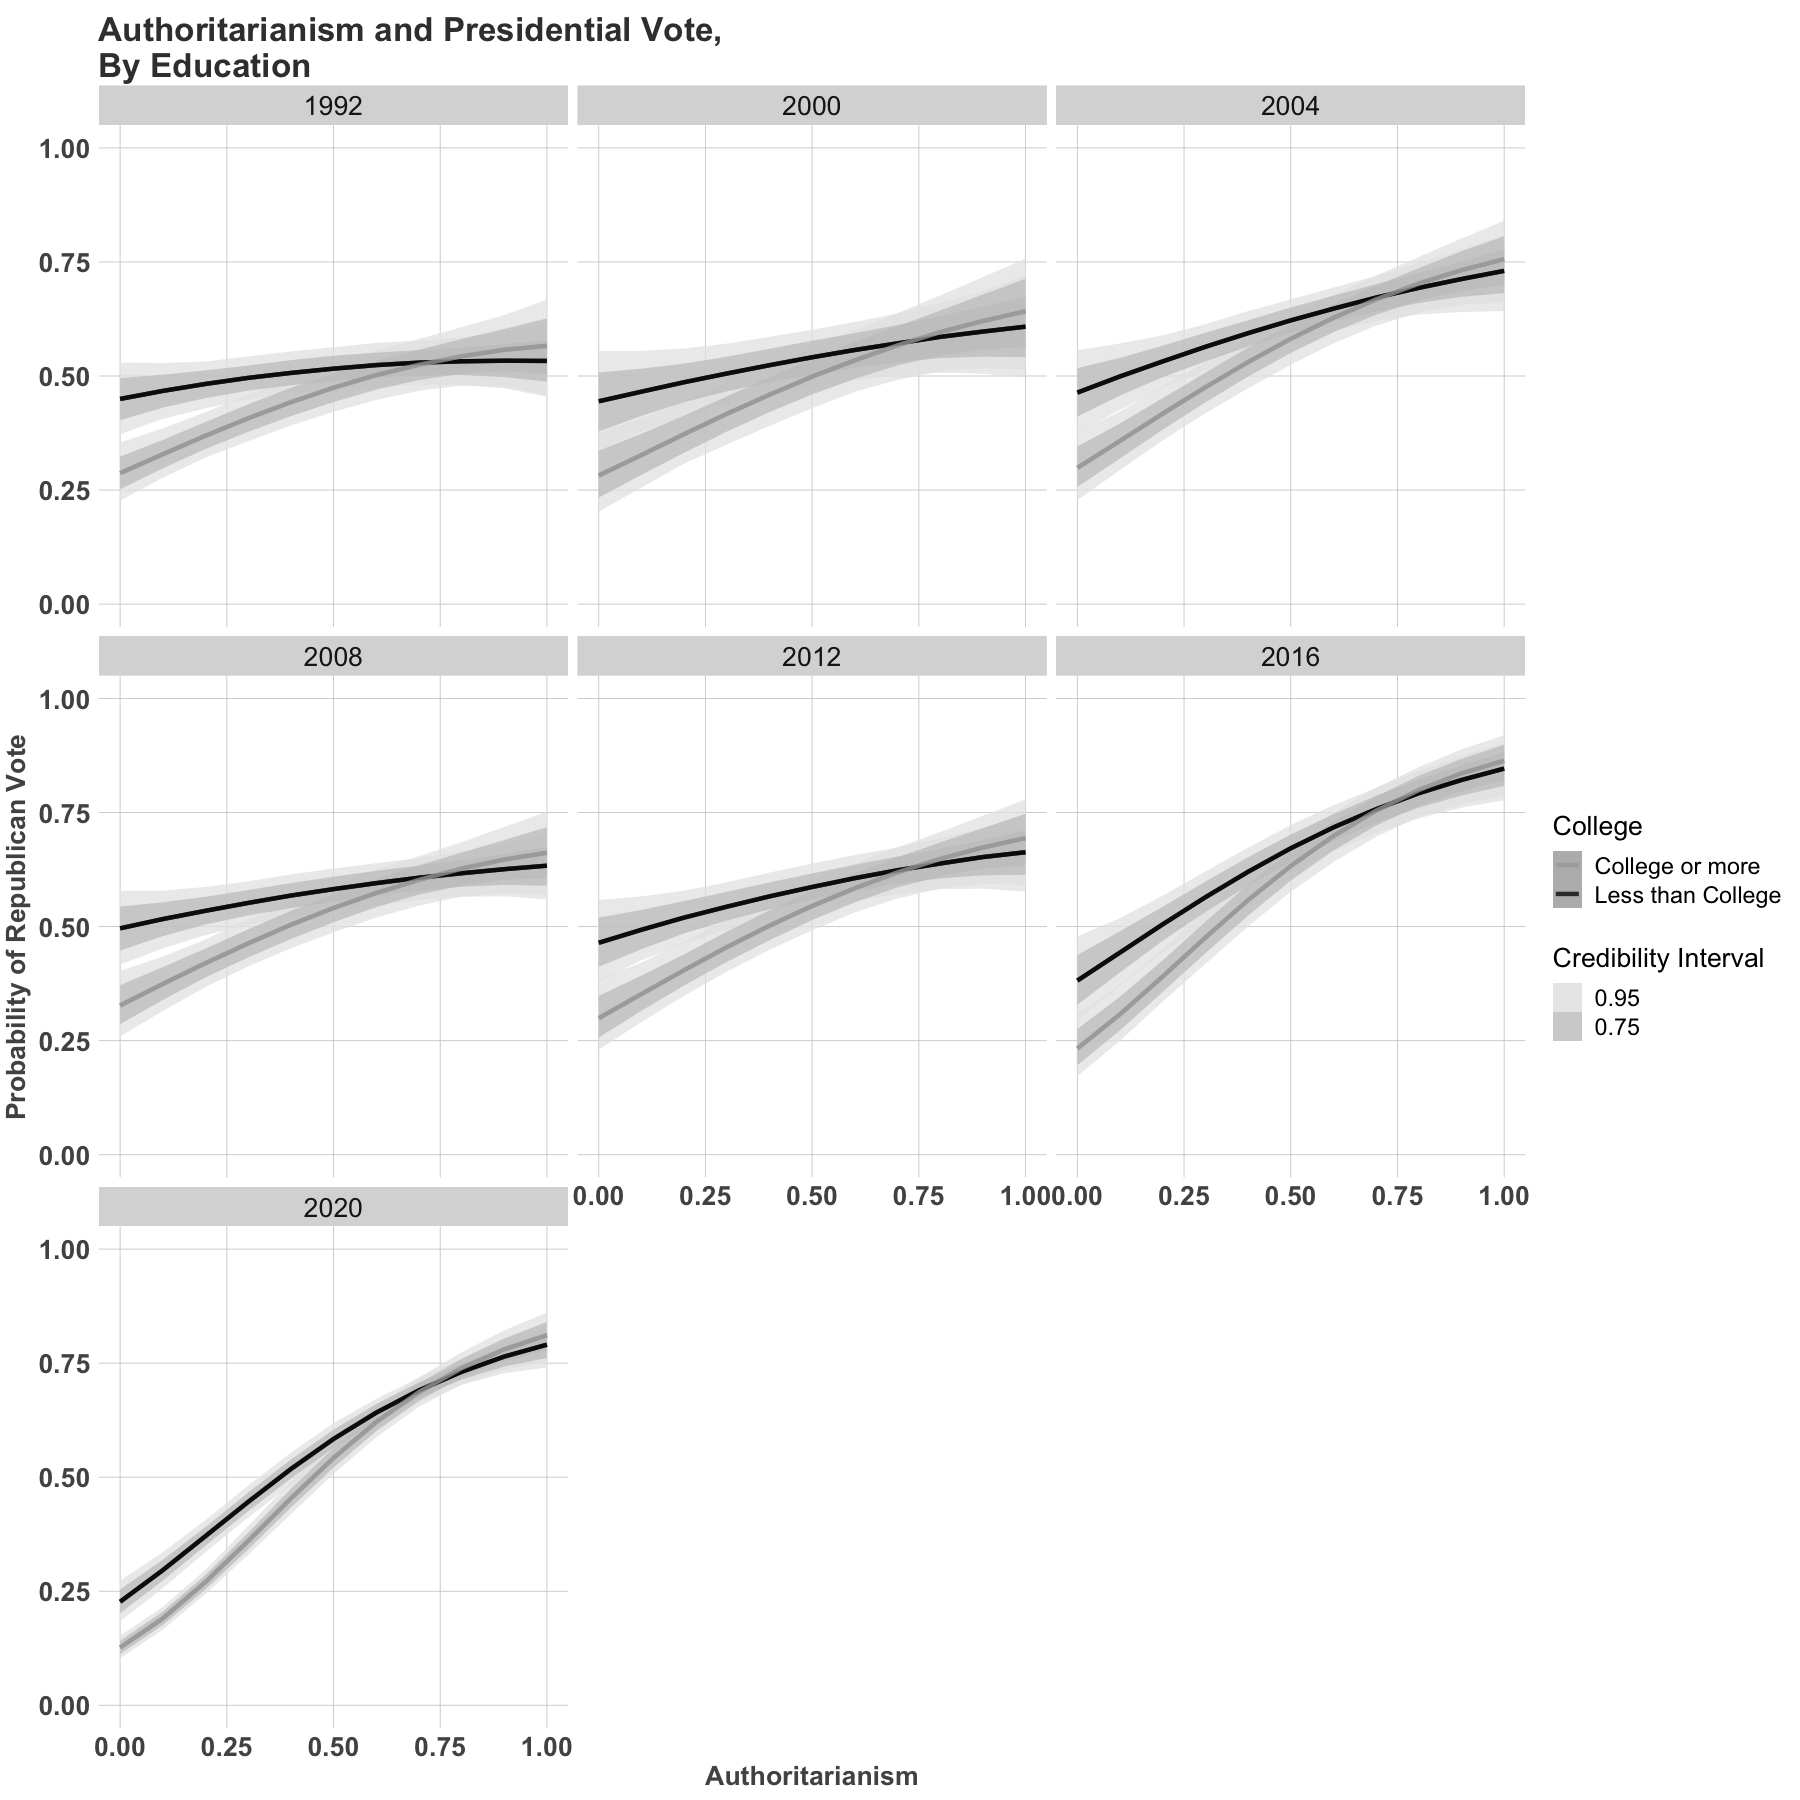

In [53]:
education  = vote_models[[4]]

fixed_data = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) 
                   
model1 = fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_linpred_draws(education) %>% 
                                                      mutate(Vote_Republican = plogis(.linpred))  %>% 
                                        mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) 
          
          
options(repr.plot.width=15, repr.plot.height=15)
                                         
model1 %>%  ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75),  alpha = 0.75) + 
       ggtheme +       scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2))+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote,\nBy Education") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism")  +   scale_colour_manual(name="College", values=c("darkgrey", "black")) 
  

# Affective Polarization

Here are the bar plots for our affective analysis plots (Figures 3,4)

`summarise()` has grouped output by '.group', 'Authoritarianism'. You can override using the `.groups` argument.


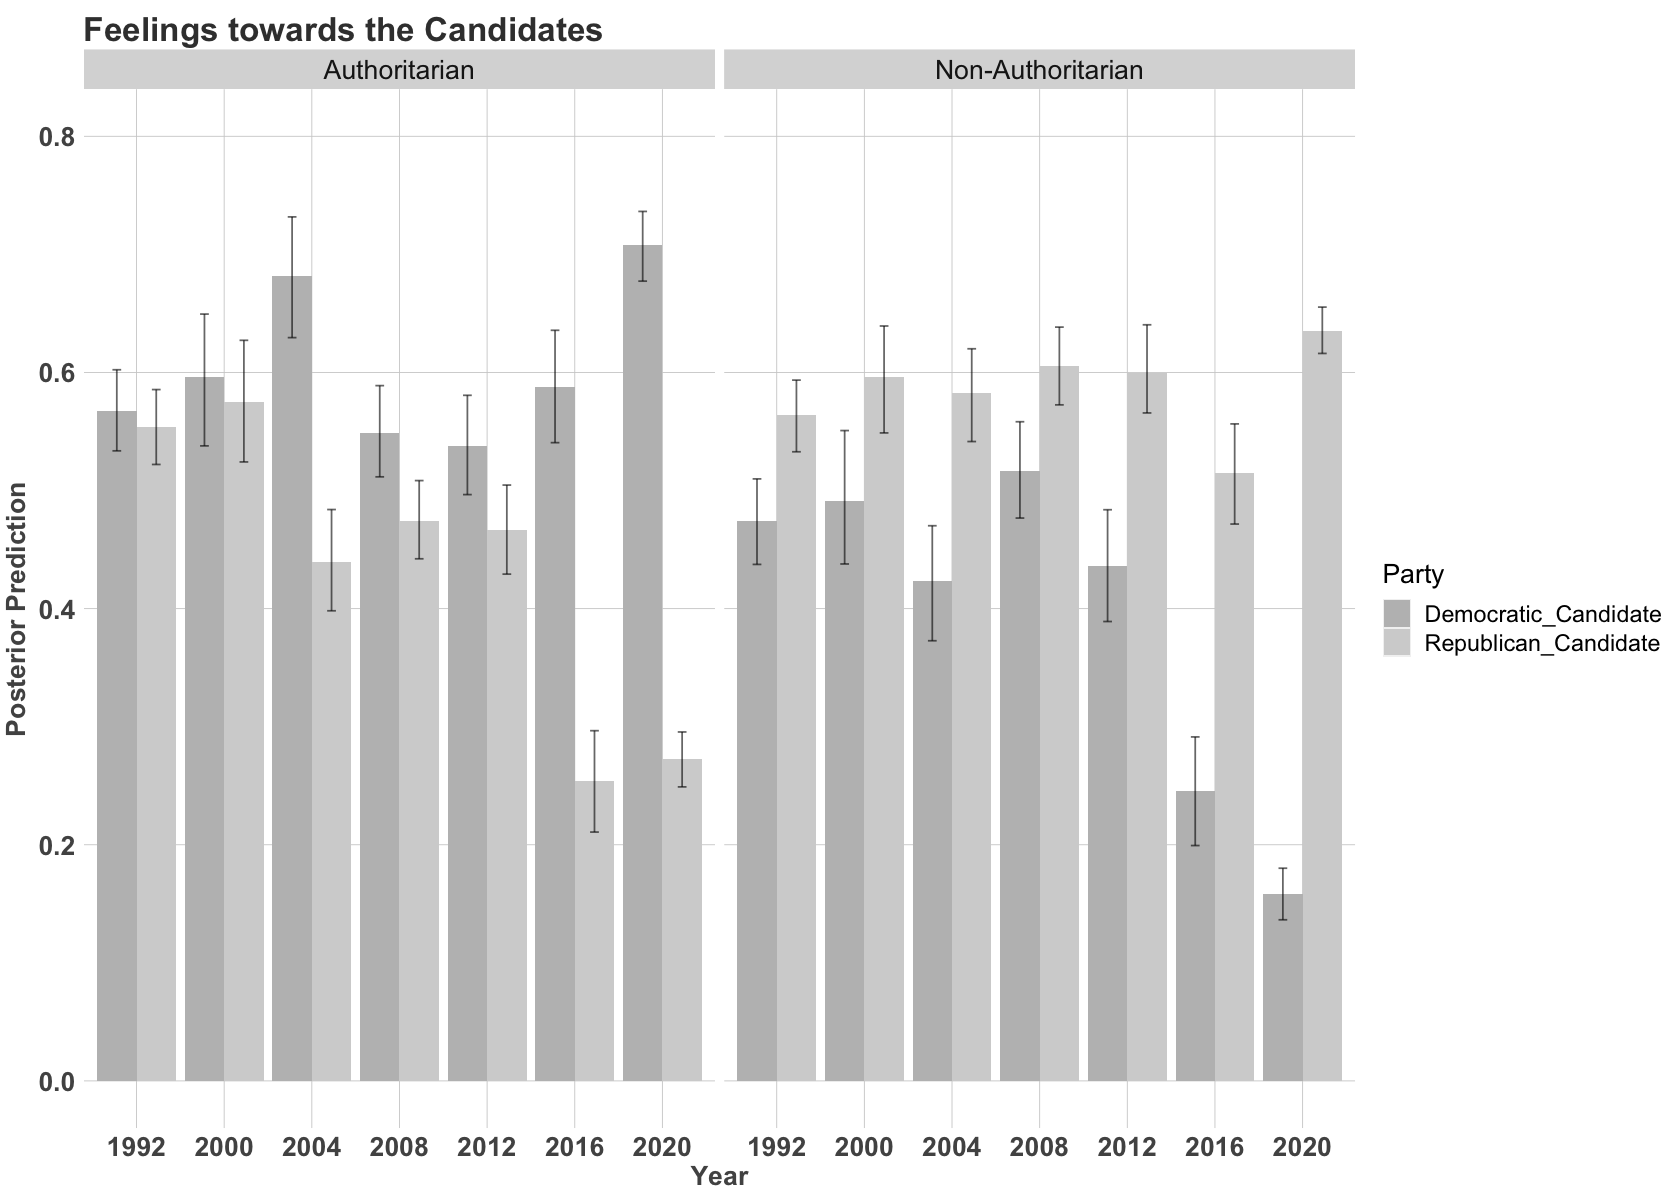

In [23]:
options(repr.plot.width=14, repr.plot.height=10)

reps = affect[[1]]
dems = affect[[2]]
repc = affect[[3]]
demc = affect[[4]]
                   
fixed_data = data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism)  %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)   

data.frame(rbind( fixed_data  %>% add_linpred_draws(reps, draws = 1000)   %>% mutate(.group = "Republicans"),
                              fixed_data  %>% add_linpred_draws(dems, draws = 1000)   %>% mutate(.group = "Democrats"),
                              fixed_data  %>% add_linpred_draws(repc, draws = 1000)   %>% mutate(.group = "Republican_Candidate"),
                              fixed_data  %>% add_linpred_draws(demc, draws = 1000)   %>% mutate(.group = "Democratic_Candidate"))) %>% 
                               mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                group_by(.group, Authoritarianism, year) %>% 
                                summarise(mean = quantile(.linpred, prob =0.5),
                                          min  = quantile(.linpred, prob =0.025),
                                          max  = quantile(.linpred, prob =0.975)  
                                ) %>% as_tibble() %>% filter(.group %in% c("Democratic_Candidate", "Republican_Candidate")) %>%                                 
                                ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y=mean,  fill =.group), stat="identity", position=position_dodge()) + 
                                geom_bar(stat="identity", position=position_dodge())+
                                scale_fill_manual(name="Party", values=c("gray", "lightgray"))+
                                geom_errorbar(width=.2, position=position_dodge(0.9), alpha = 0.6) +
                                 facet_wrap(~Authoritarianism)+ggtitle("Feelings towards the Candidates") +
                                 scale_y_continuous("Posterior Prediction", limits=c(0, 0.8)) +ggtheme +
                                 scale_x_discrete("Year")

`summarise()` has grouped output by '.group', 'Authoritarianism'. You can override using the `.groups` argument.


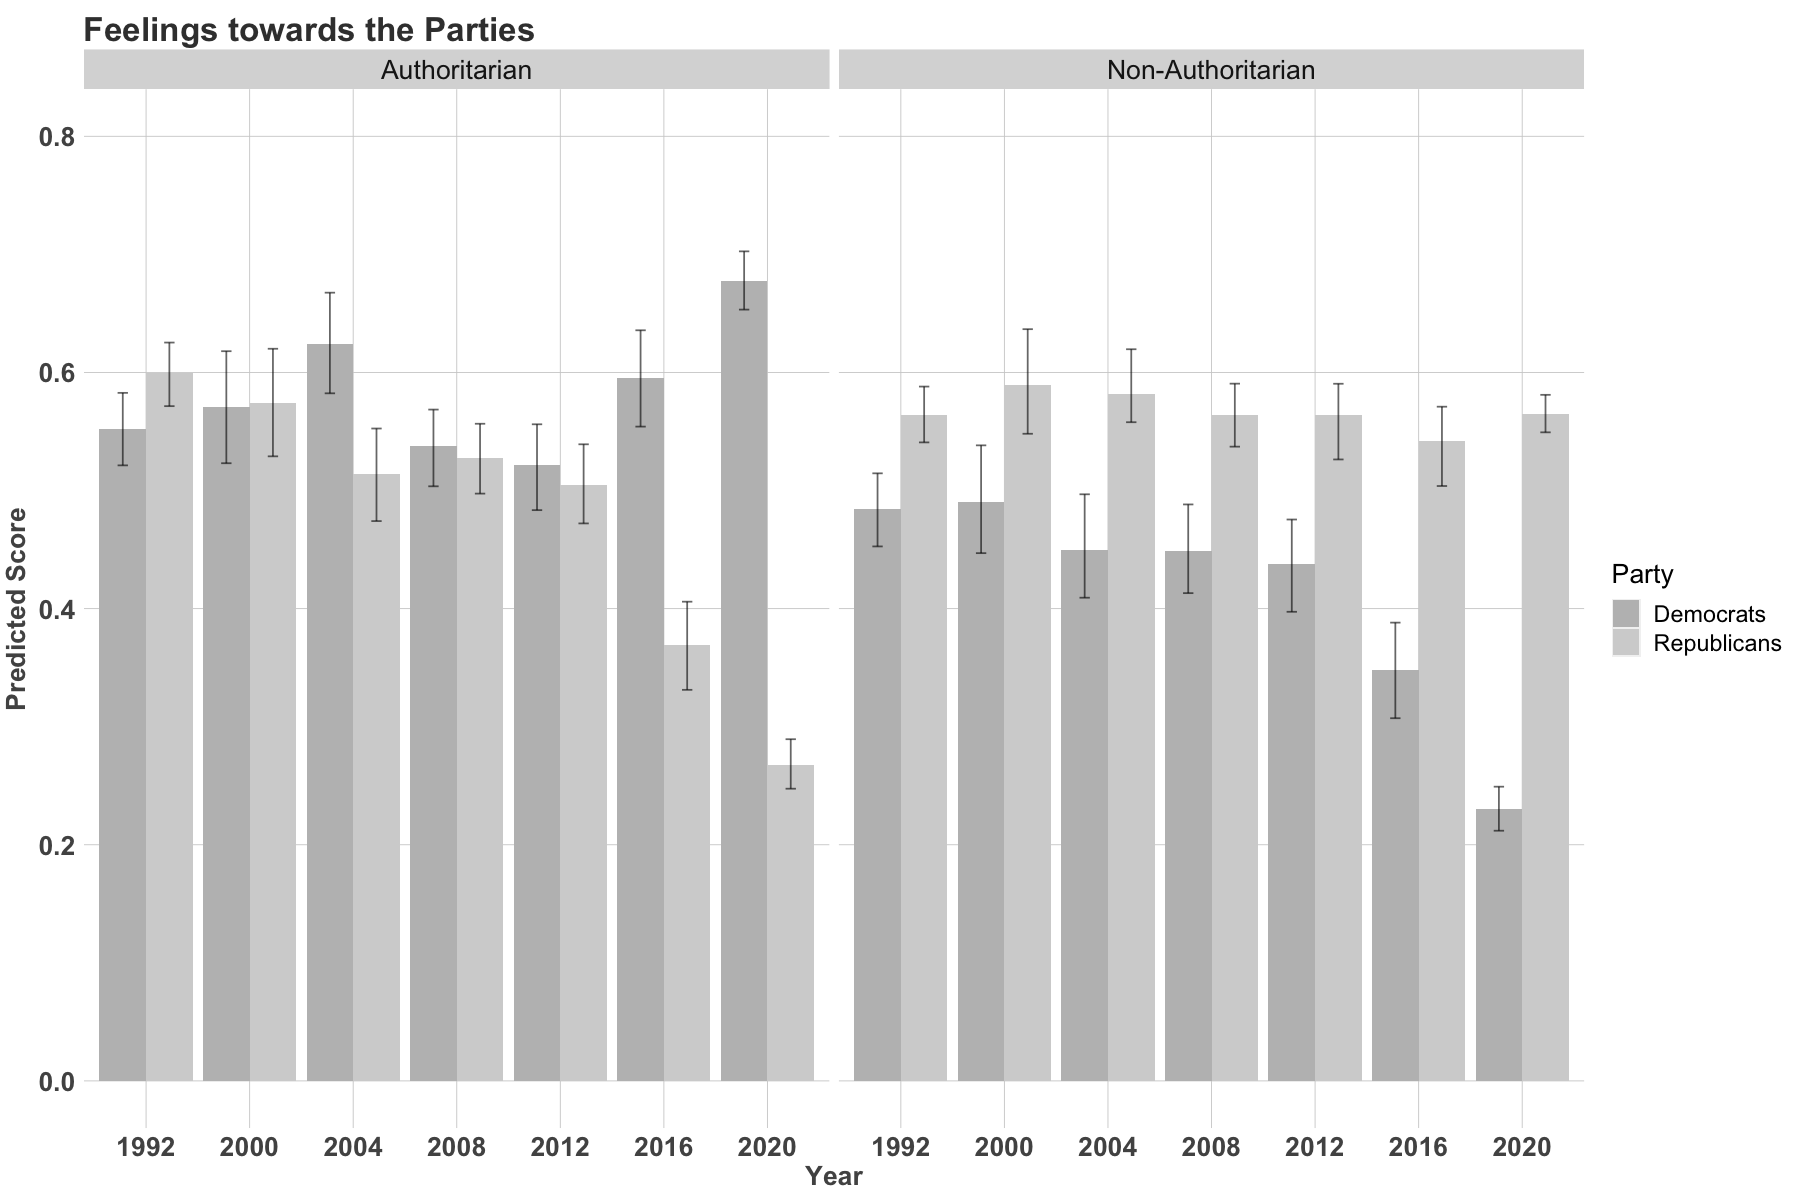

In [22]:
options(repr.plot.width=15, repr.plot.height=10)

data.frame(rbind( fixed_data  %>% add_linpred_draws(reps, draws = 1000)   %>% mutate(.group = "Republicans"),
                              fixed_data  %>% add_linpred_draws(dems, draws = 1000)   %>% mutate(.group = "Democrats"),
                              fixed_data  %>% add_linpred_draws(repc, draws = 1000)   %>% mutate(.group = "Republican_Candidate"),
                              fixed_data  %>% add_linpred_draws(demc, draws = 1000)   %>% mutate(.group = "Democratic_Candidate"))) %>% 
                               mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                group_by(.group, Authoritarianism, year) %>% 
                                summarise(mean = quantile(.linpred, prob =0.5),
                                          min  = quantile(.linpred, prob =0.025),
                                          max  = quantile(.linpred, prob =0.975)  
                                ) %>% as_tibble() %>% filter(.group %in% c("Democrats", "Republicans")) %>%                                 
                                ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y=mean,  fill =.group), stat="identity", position=position_dodge()) + 
                                geom_bar(stat="identity", position=position_dodge())+
                                scale_fill_manual(name="Party", values=c("gray", "lightgray"))+
                                geom_errorbar(width=.2, position=position_dodge(0.9), alpha = 0.6) +
                                 facet_wrap(~Authoritarianism)+ggtitle("Feelings towards the Parties") +
                                 scale_y_continuous("Predicted Score", limits=c(0, 0.8)) +ggtheme +
                                 scale_x_discrete("Year")

In [25]:
## Write a function to calculate margins, main effects
margins = function(fixed = fixed, model_fit){
                        out1 = fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college) , income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = min(authoritarianism) ) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        out2 =  fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = max(authoritarianism) ) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        r = fixed %>% na.omit() %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  
                                                                                                            authoritarianism = 0 )%>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) 
                        r$marginal = out2$.epred - out1$.epred 
                        return(r)
                        }

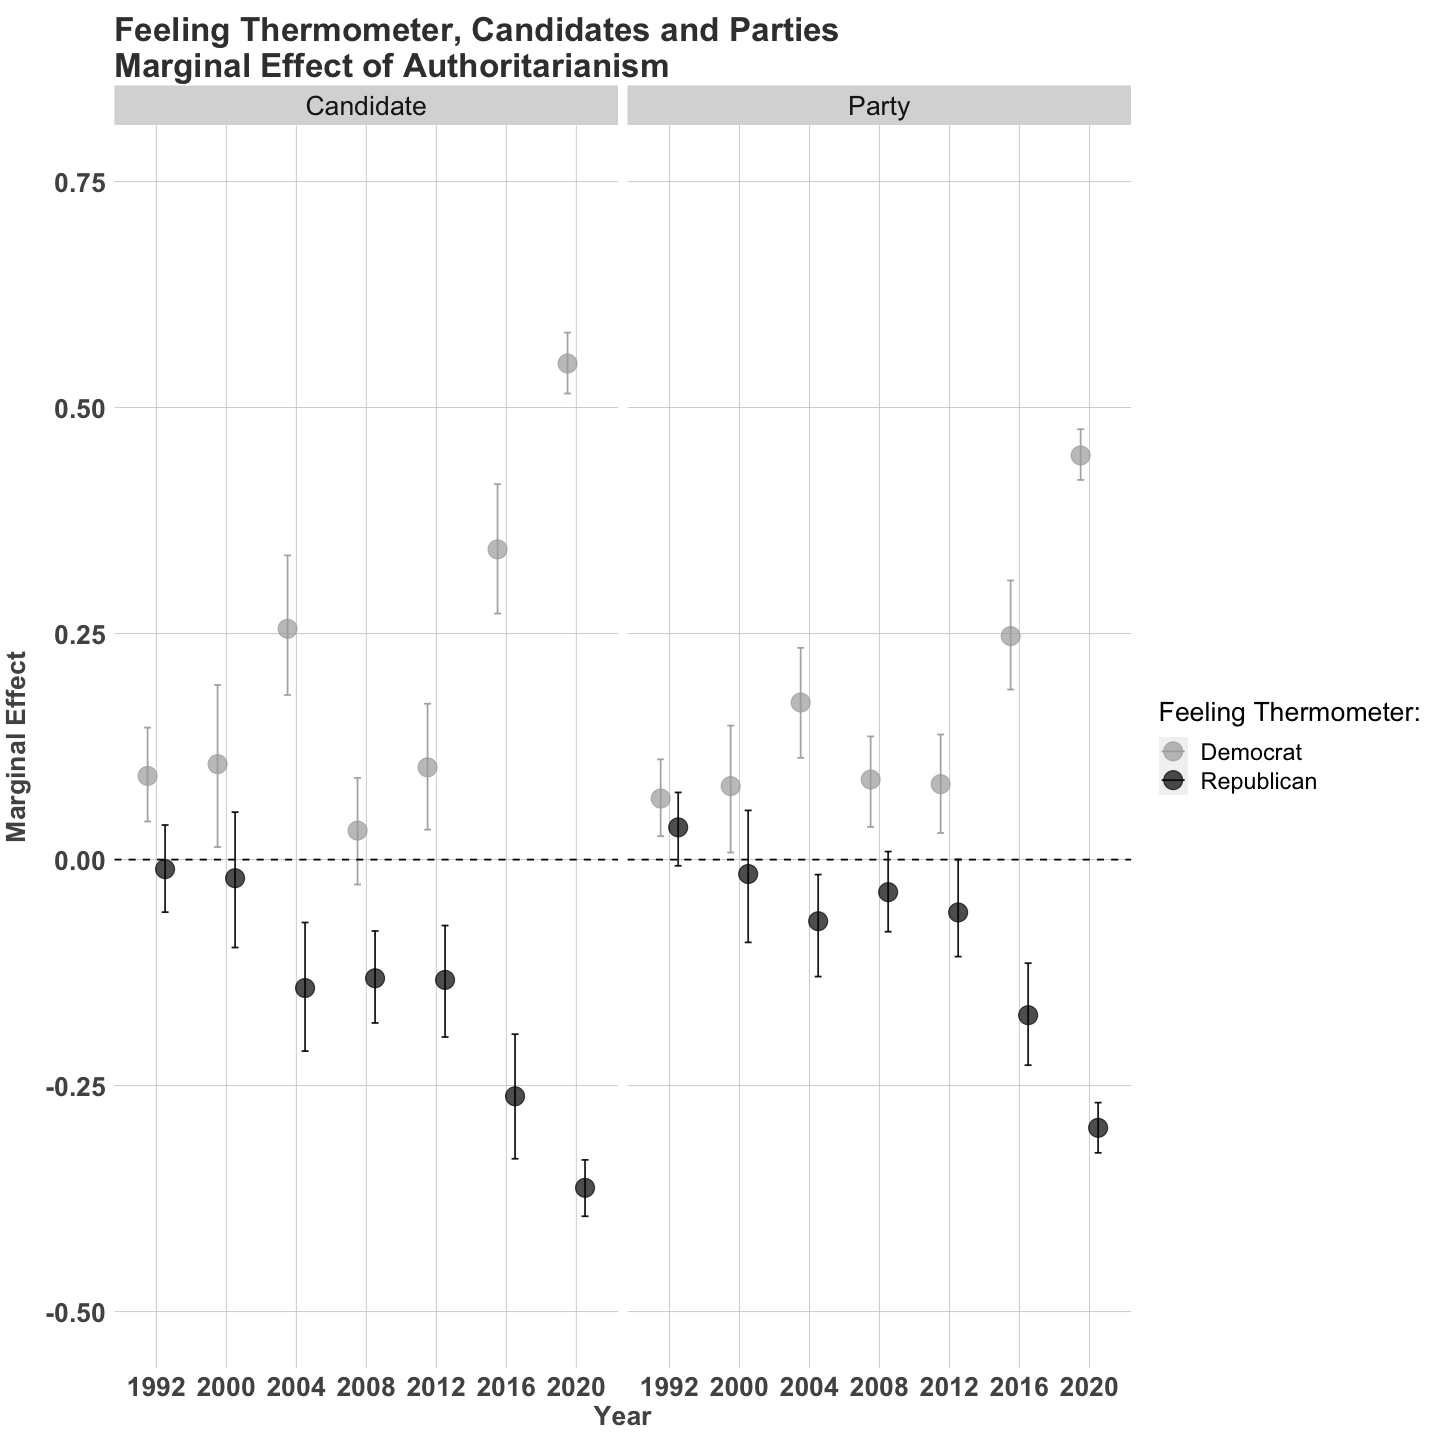

In [57]:
 options(repr.plot.width=12, repr.plot.height=12)

data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Republicans"),

    margins(fixed_data, model_fit = dems) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Democratic_Candidate"))) %>%  
    mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>% 
    mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidate", "Party")) %>% 

    ggplot(aes(x = factor(year), 
                  y = mean, ymin=min, 
                  ymax=max, colour = as.factor(pid), group = as.factor(pid)))+ facet_wrap(~candidate) +
  geom_point(size=5,  alpha = 0.7, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.20, alpha=0.9, position = position_dodge(width = 0.5)) +
  ggtitle("Feeling Thermometer, Candidates and Parties\nMarginal Effect of Authoritarianism") +
  ggtheme + 
  scale_y_continuous("Marginal Effect", limits=c(-0.5,0.75)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") + 
  scale_colour_manual(name="Feeling Thermometer:", values=c("darkgrey", "black"))



I did change this figure a bit. Let me know what you think. It seems particularly striking with everything on one plot.

# Education and Affective Polarization

Here are calculate the effects of authoritarianism for REP FT - DEM FT and REP CAND FT - DEM CAND FT

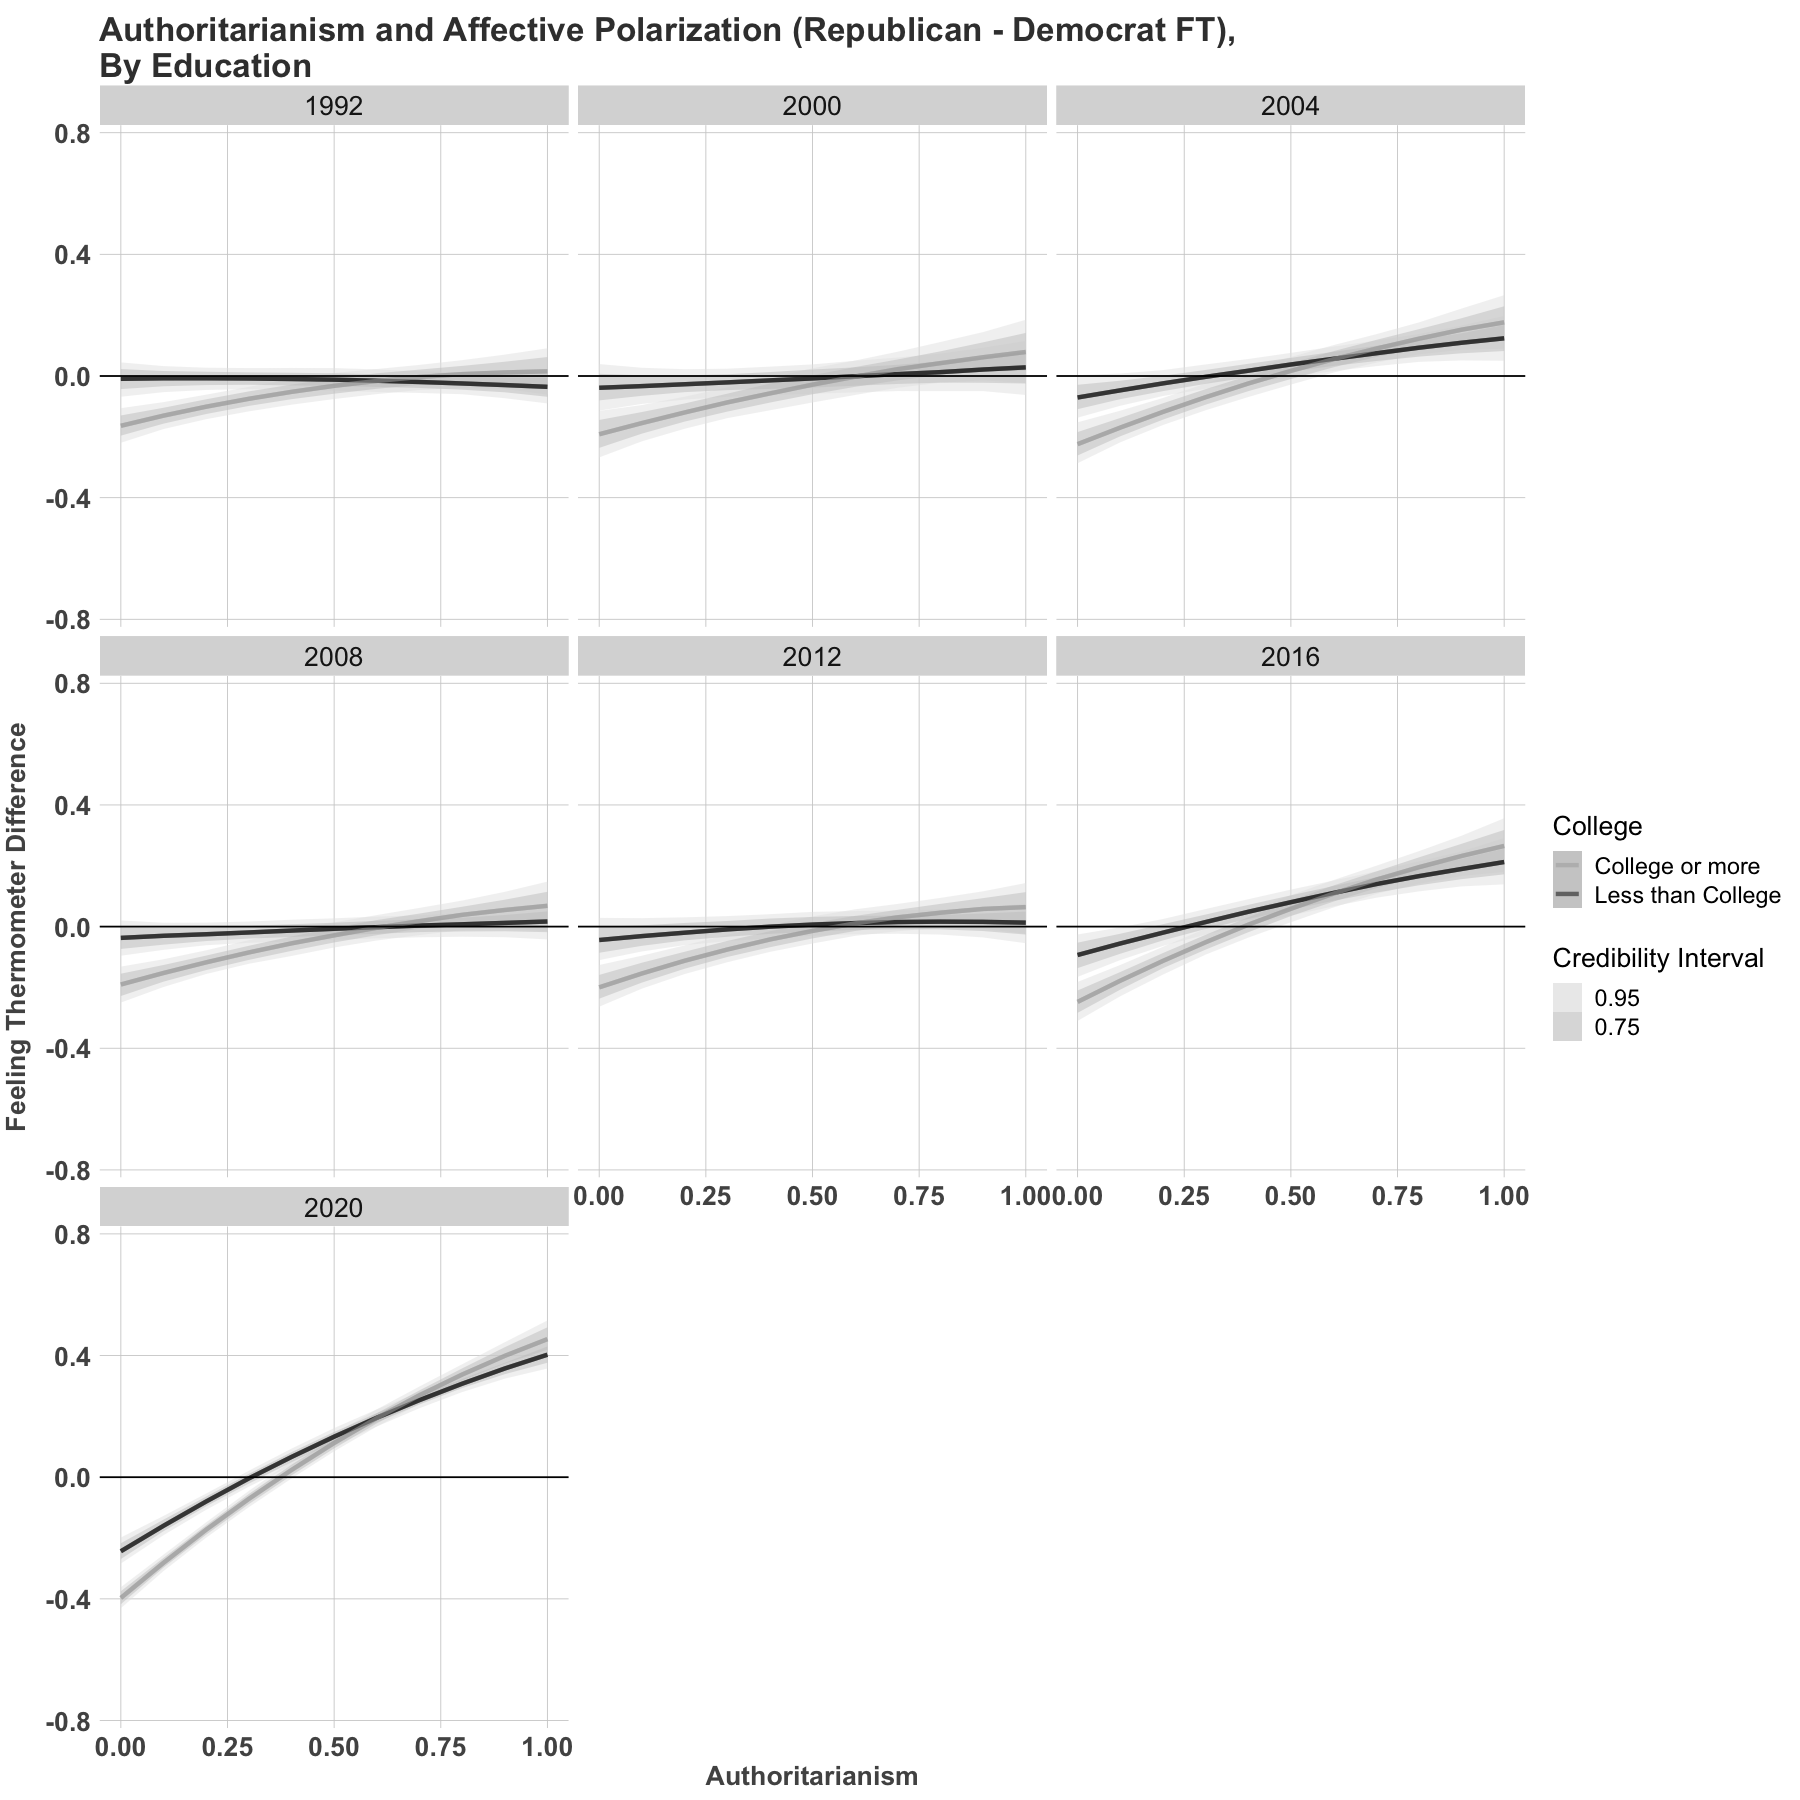

In [45]:
options(repr.plot.width=15, repr.plot.height=15)

difference = affect[[5]]
fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_linpred_draws(difference) %>% 
                                                      mutate(Feeling = .linpred)  %>%  
                                                      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%

     ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75),  alpha = 0.5) +
      ggtheme + geom_hline(yintercept = 0)+
      scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  # Format the grid
  ggtitle("Authoritarianism and Affective Polarization (Republican - Democrat FT),\nBy Education") +
  scale_y_continuous("Feeling Thermometer Difference", limits=c(-0.75,0.75))+
  scale_x_continuous("Authoritarianism")   +   scale_colour_manual(name="College", values=c("darkgrey", "black")) 
                 

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.


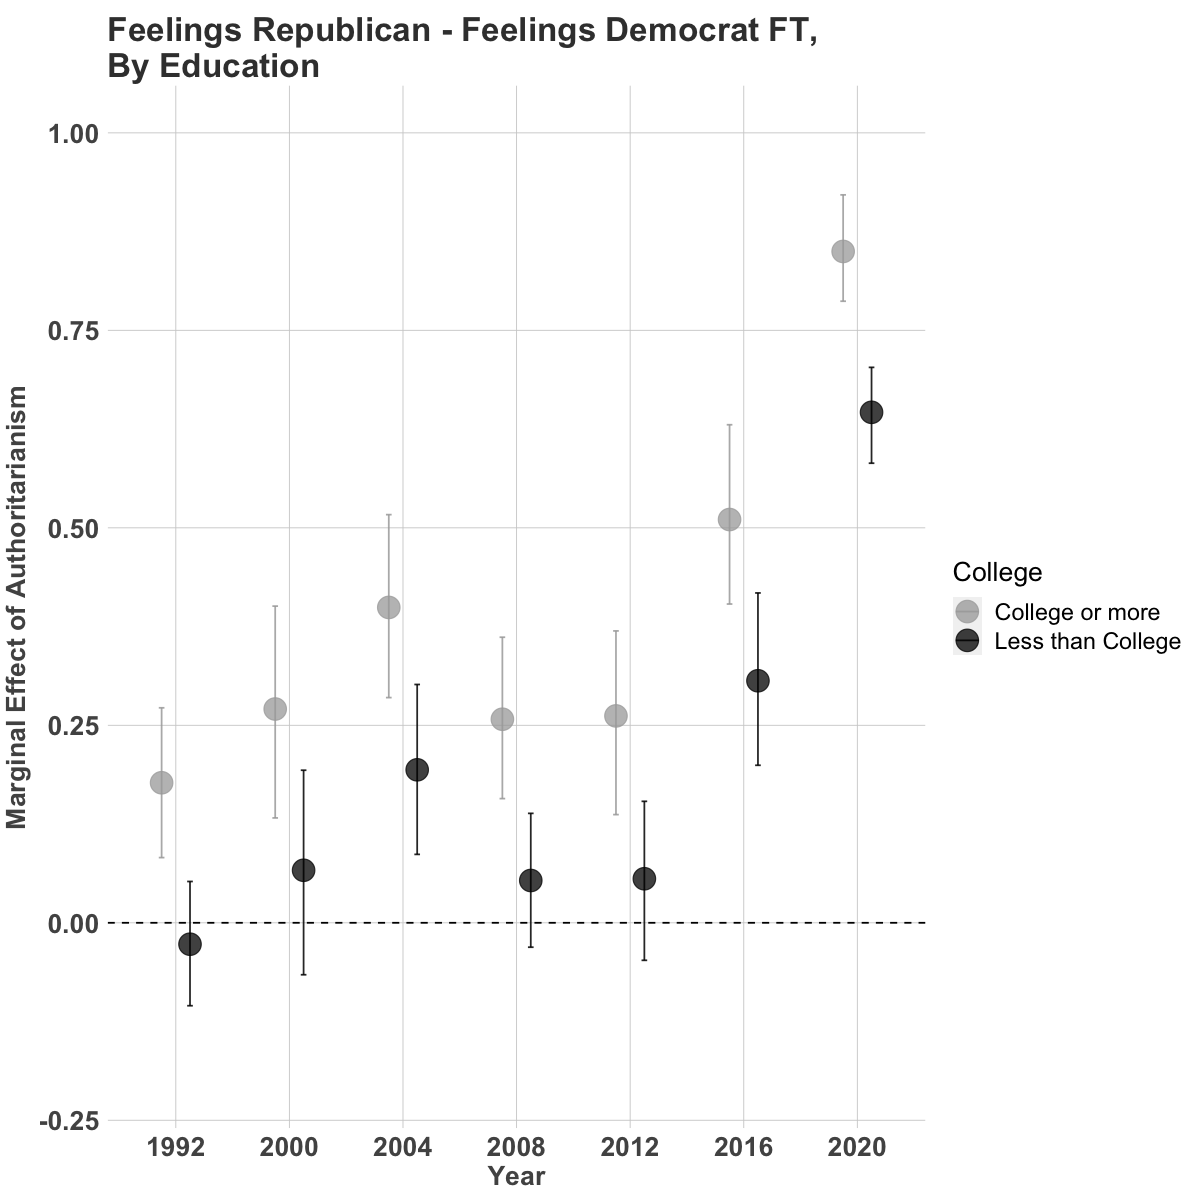

In [46]:
options(repr.plot.width=10, repr.plot.height=10)

marginal_by_ed(fixed = fixed, model_fit = difference)  %>% group_by(year, college) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
                                          mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%

ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(Education), group = as.factor(Education)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Feelings Republican - Feelings Democrat FT,\nBy Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.2,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

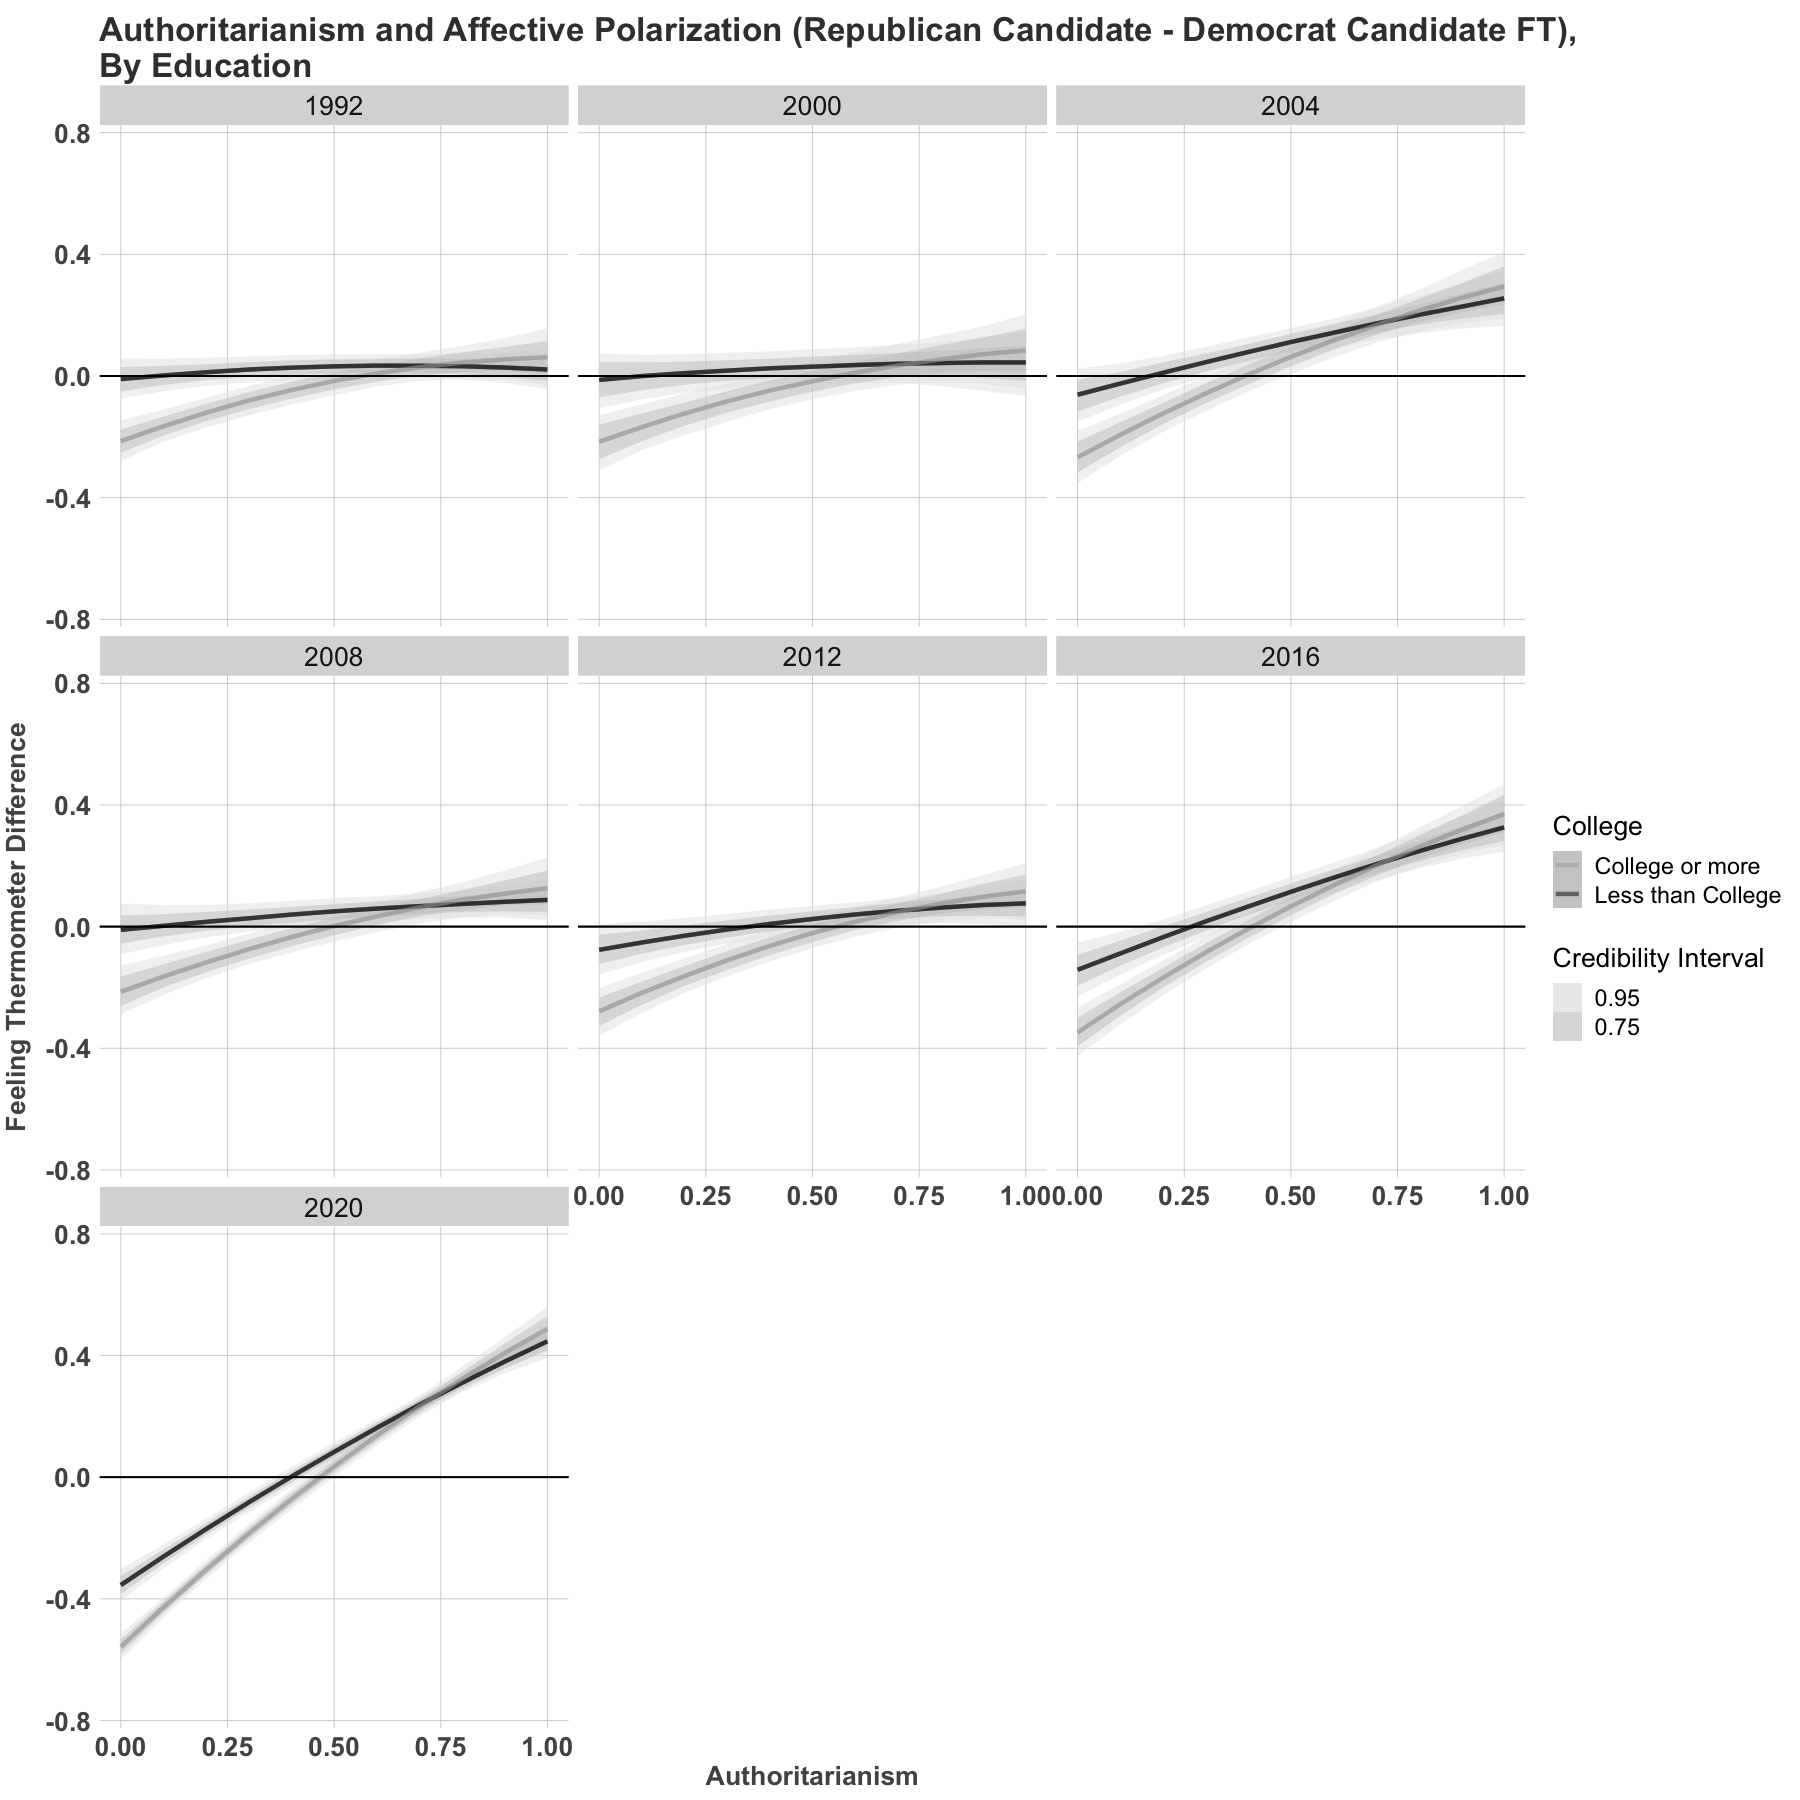

In [49]:
options(repr.plot.width=15, repr.plot.height=15)
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/affect2.rda")
fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_linpred_draws(extremity2) %>% 
                                                      mutate(Feeling = .linpred)  %>%  
                                                      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%

     ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75),  alpha = 0.5) +
      ggtheme + geom_hline(yintercept = 0)+
      geom_hline(yintercept = 0)+
      scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  # Format the grid
  ggtitle("Authoritarianism and Affective Polarization (Republican Candidate - Democrat Candidate FT),\nBy Education") +
  scale_y_continuous("Feeling Thermometer Difference", limits=c(-0.75,0.75))+
  scale_x_continuous("Authoritarianism")   +   scale_colour_manual(name="College", values=c("darkgrey", "black")) 
                    

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.
Warning message:
"Removed 1 rows containing missing values (geom_point)."


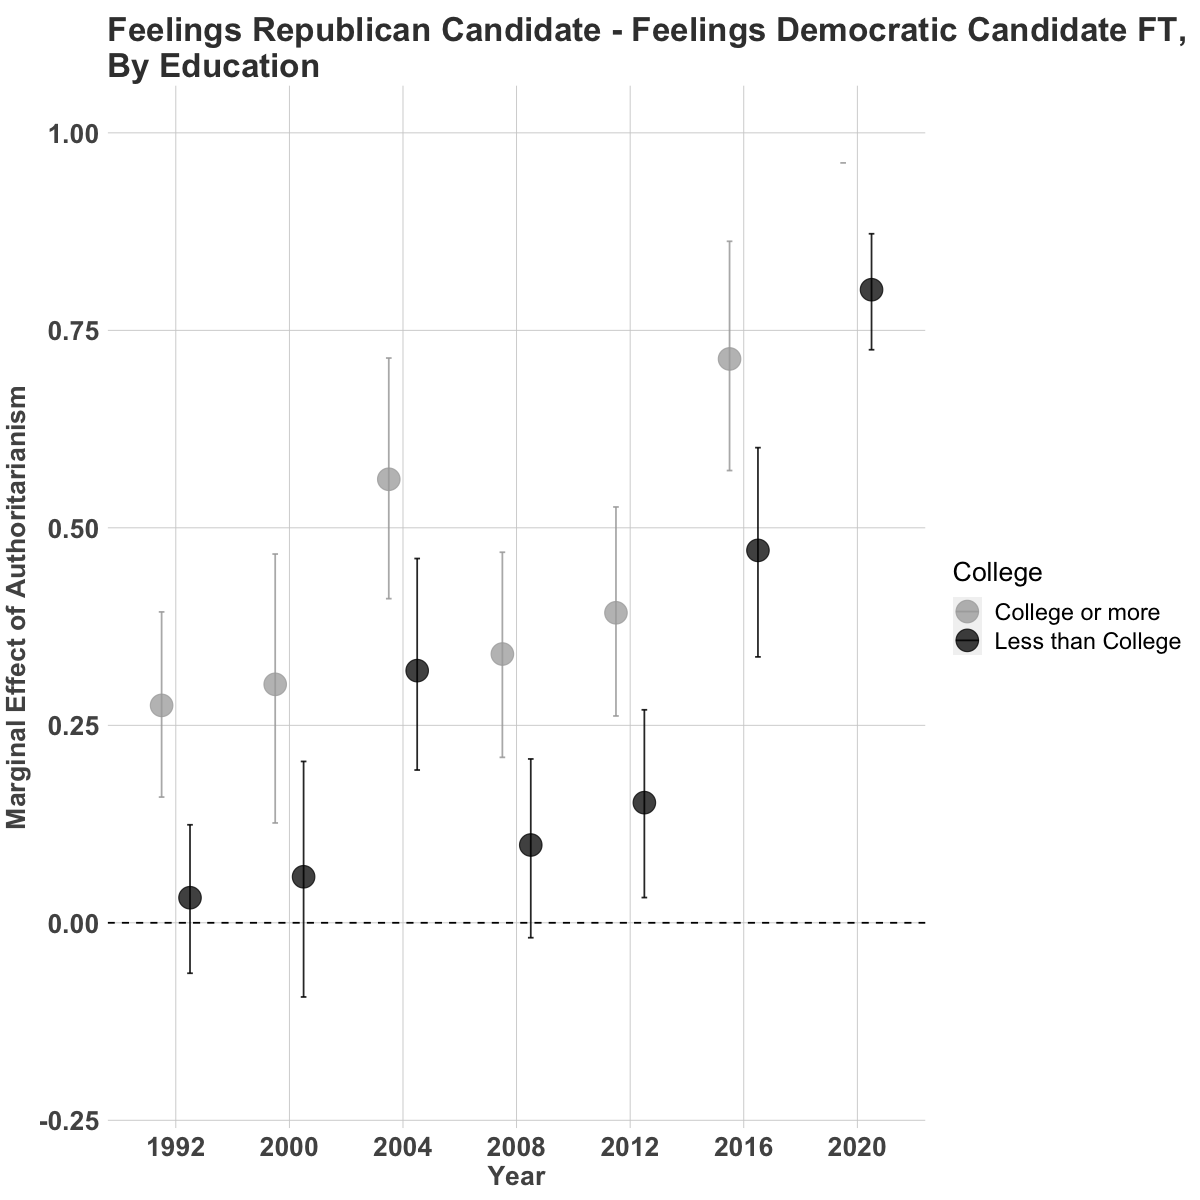

In [50]:
options(repr.plot.width=10, repr.plot.height=10)

marginal_by_ed(fixed = fixed, model_fit = extremity2)  %>% group_by(year, college) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
                                      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%

ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(Education), group = as.factor(Education)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Feelings Republican Candidate - Feelings Democratic Candidate FT,\nBy Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.2,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

Things do seem to change in 2016, 2020. There's really no effect of authoritarianism on affective polarization among non-college educated respondents before 2016

## Partisanship and Authoritarian Sorting

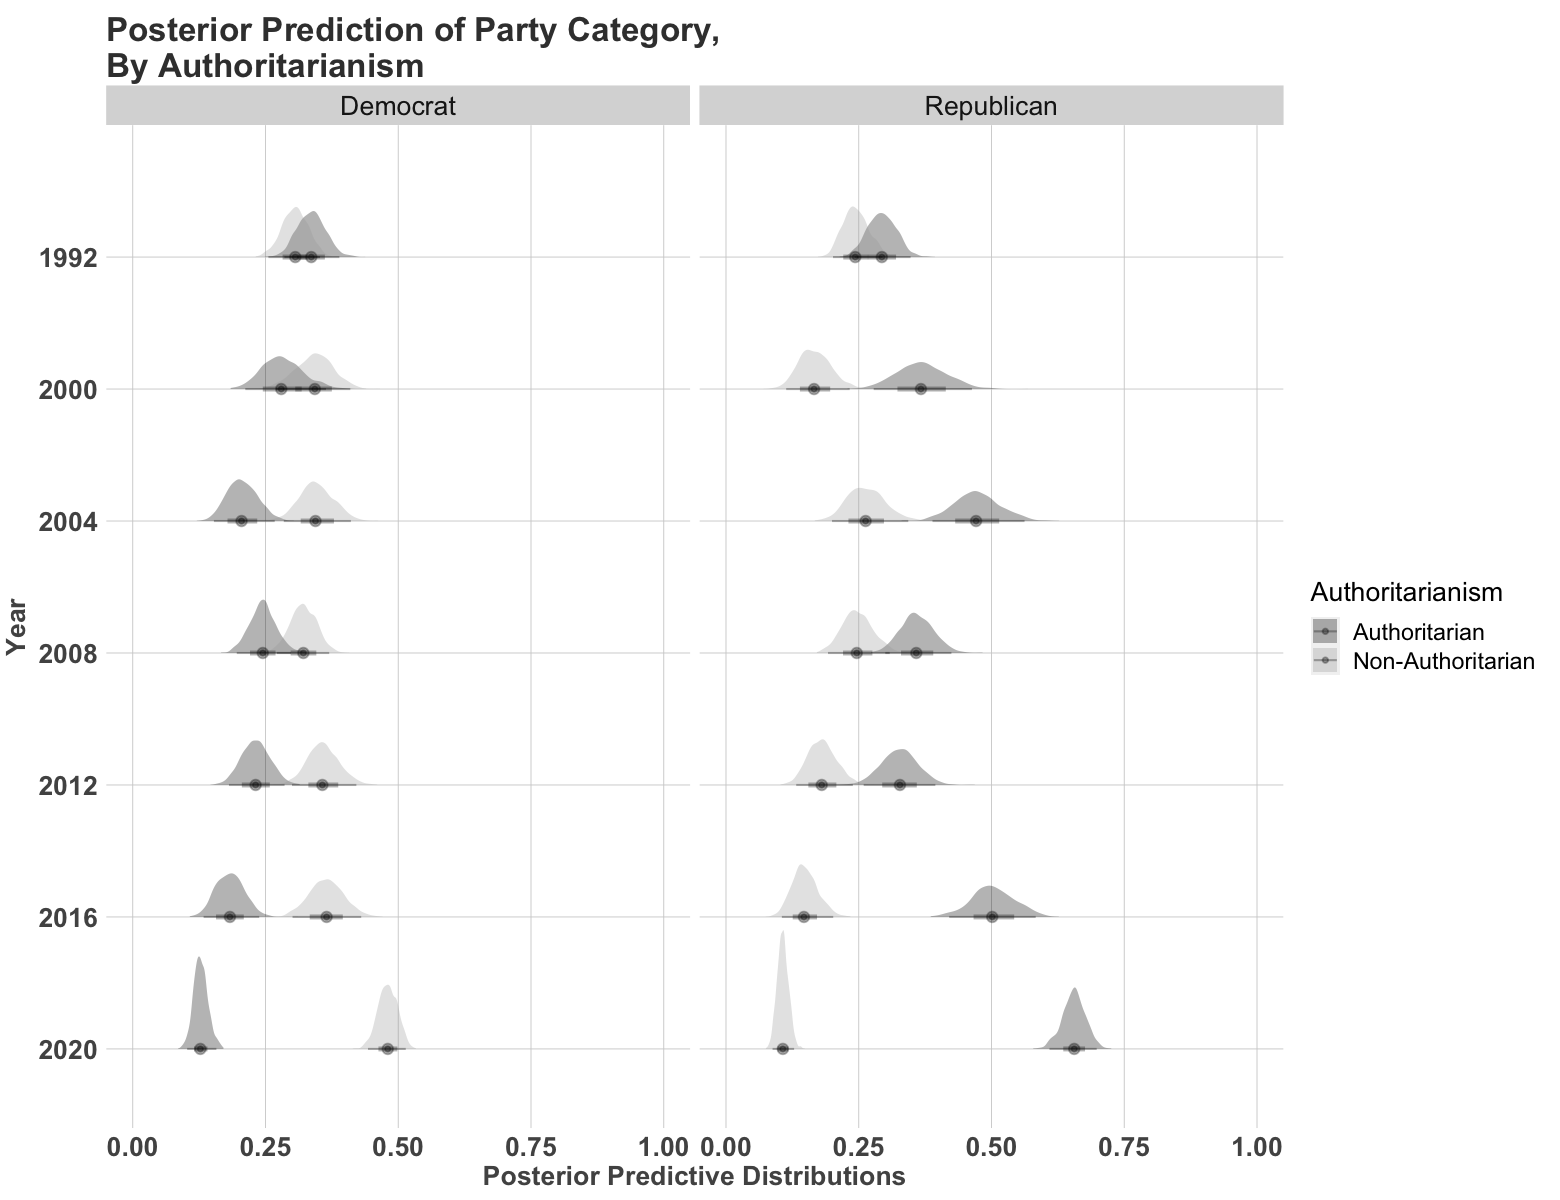

In [58]:
library(tidybayes)
options(repr.plot.width=13, repr.plot.height=10)

party = party_model[[2]]
data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(party)  %>% 
                                                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent" , `3` = "Republican")) %>%

    subset(.category != 2) %>% 
    ggplot(aes(x = .epred, y = as.factor(year), 
                                                group = as.factor(authoritarianism),  fill = Authoritarianism)) +  facet_wrap(~PID) + 
                                                stat_halfeye(alpha =0.3) + ggtheme +
  # Format the grid
  ggtitle("Posterior Prediction of Party Category,\nBy Authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits=c(0,1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name="Authoritarianism", values=c("black", "darkgrey"))

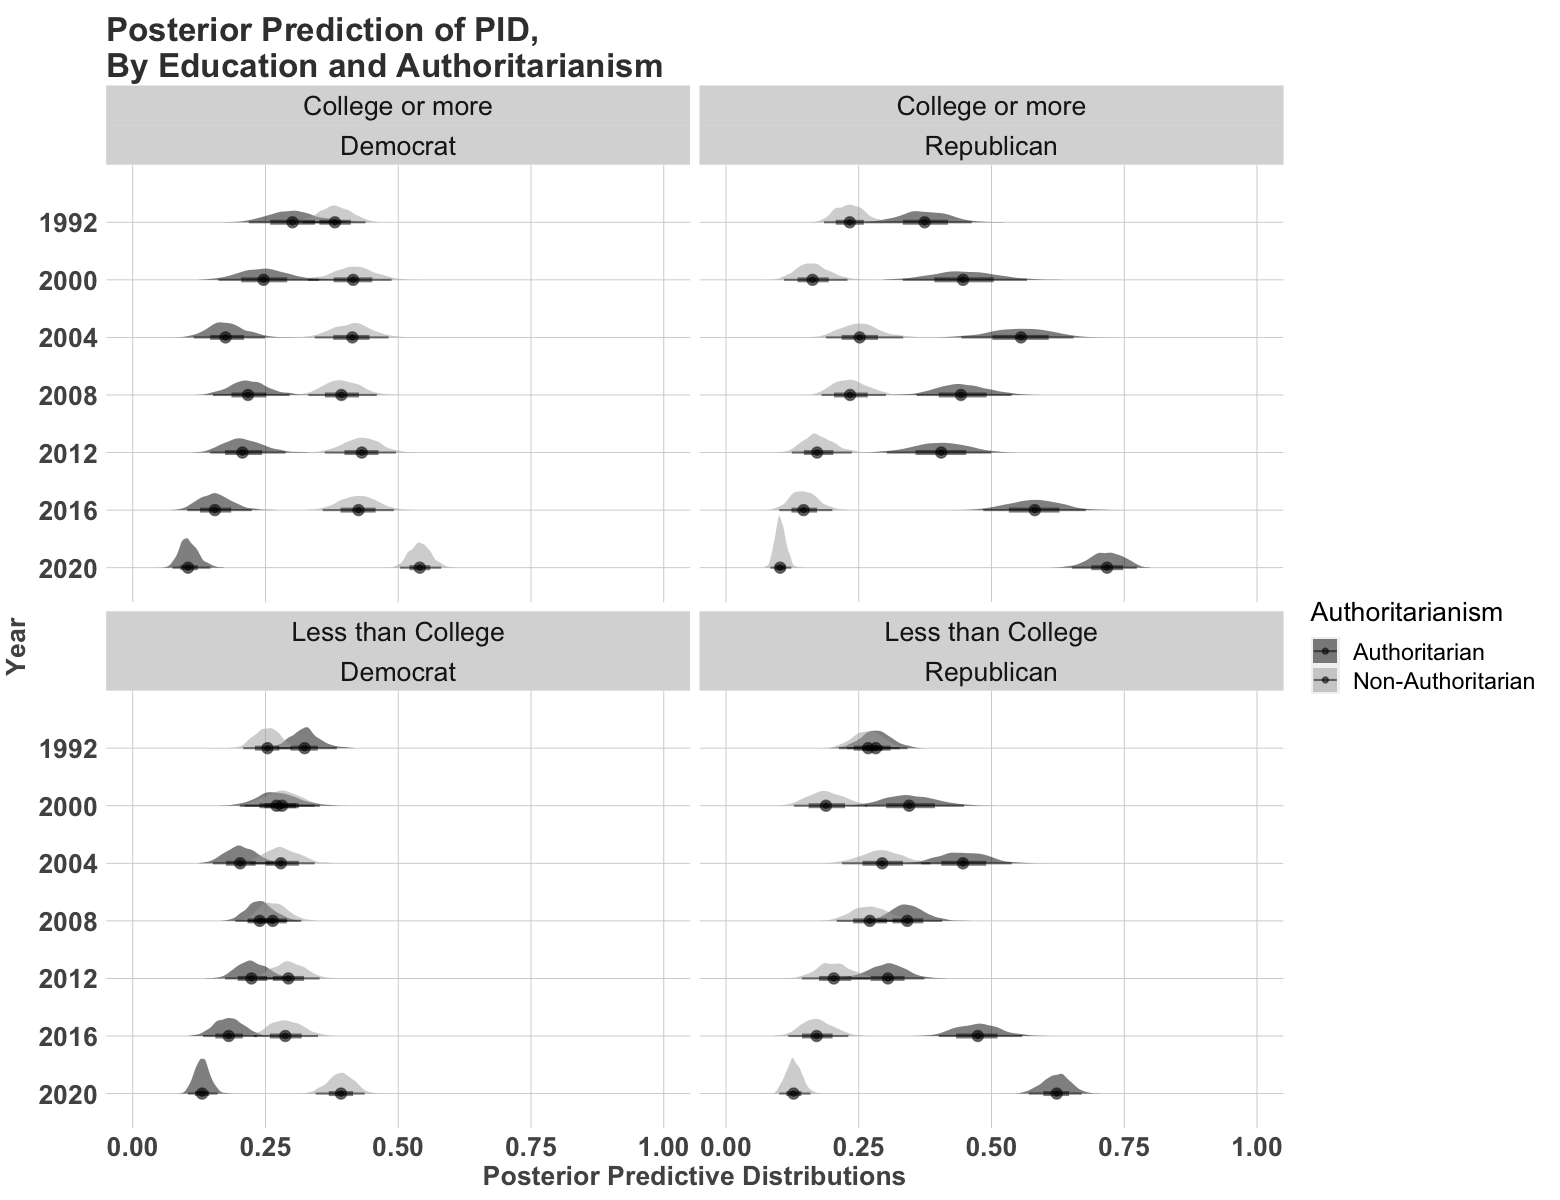

In [59]:
partyXed = party_model[[1]]
data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(partyXed)  %>% 
                                                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent" , `3` = "Republican")) %>%
                                                      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%


    subset(.category != 2) %>% 
    ggplot(aes(x = .epred, y = as.factor(year), 
                                                group = as.factor(authoritarianism),  fill = Authoritarianism)) +  
                                                facet_wrap(~Education+PID) + 
                                                stat_halfeye(alpha =0.5) + ggtheme +
  # Format the grid
  ggtitle("Posterior Prediction of PID,\nBy Education and Authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits=c(0,1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name="Authoritarianism", values=c("black", "darkgrey"))

The effect of authoritarianism among the on-college educated only begin to emerge in 2016. Here's another interesting graph. Authoritarianism has a relatively flat effect in 2012, 2008.


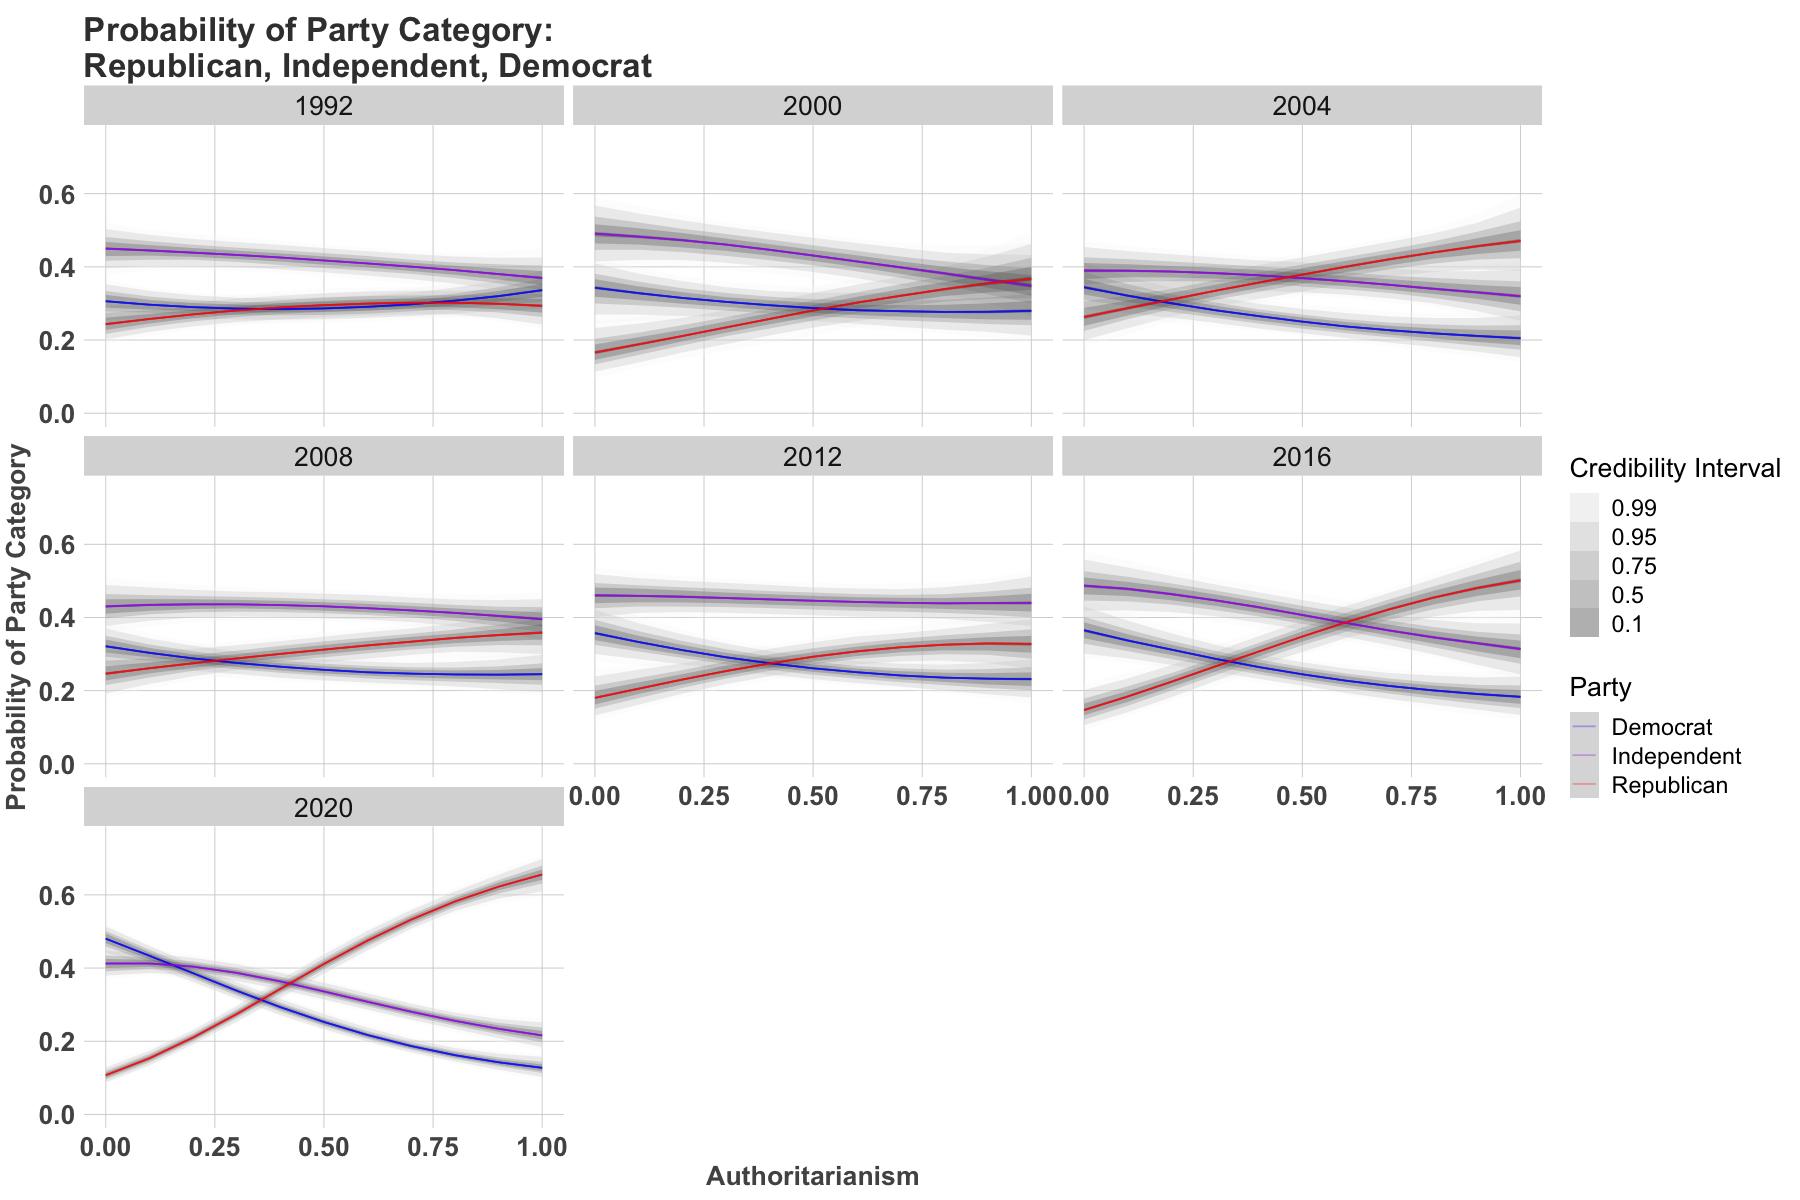

In [32]:
 options(repr.plot.width=15, repr.plot.height=10)

fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(party)  %>%  
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican" ))  %>%  
                                               #       subset(.category != 2)  %>%
      ggplot(aes(x = authoritarianism, color = PID)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = .epred), .width = c(.1, .5, 0.75, 0.95, 0.99), size = 0.5,  alpha = 0.3) +
      scale_color_manual(name="Party",values = c("blue", "purple", "red"))+ ggtheme + 
      scale_fill_brewer(name="Credibility Interval", palette = "Greys")+ 

  # Format the grid
  ggtitle("Probability of Party Category:\nRepublican, Independent, Democrat") +
  scale_y_continuous("Probability of Party Category", limits=c(0,0.75))+
  scale_x_continuous("Authoritarianism")                                                        
                                                                        
     


Authoritarians clearly shift to the Republican Party, but really only in 2004, and then again in 2016, 2020.

# Mediation and Moderation

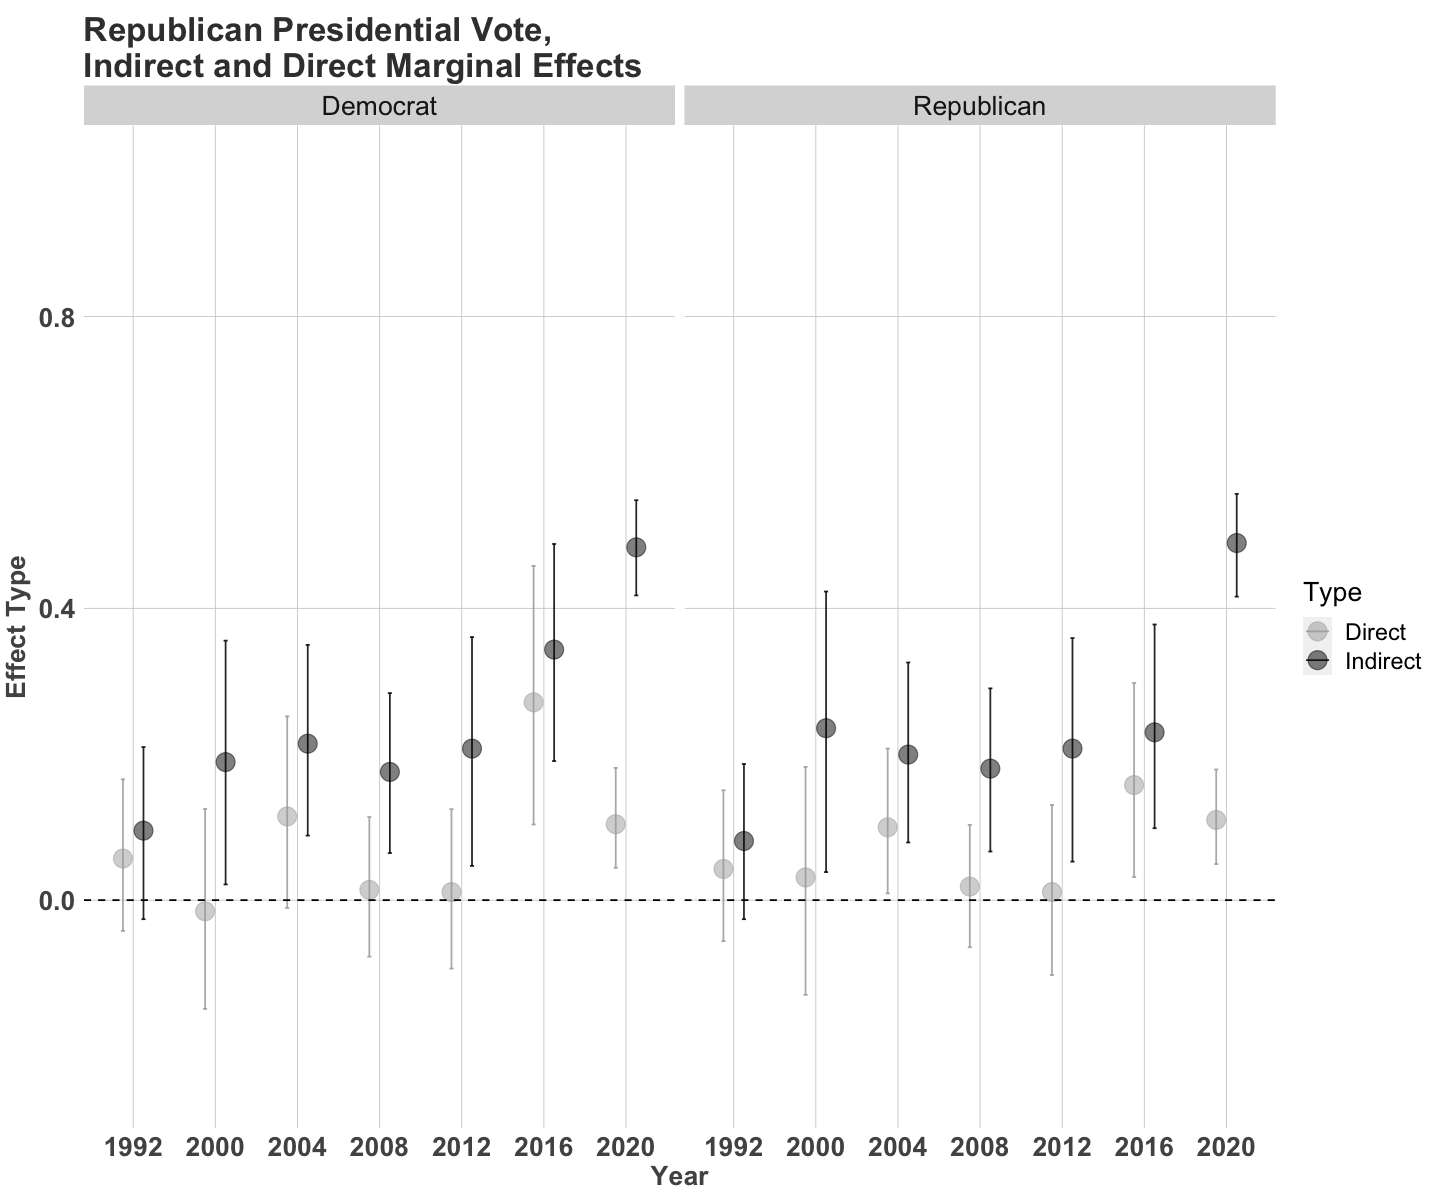

In [60]:


options(repr.plot.width=12, repr.plot.height=10)
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/indirect.rda")

plt = a[[1]]
plt$type = ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party = ifelse(grepl("*_0", row.names(plt)), "Democrat", "Republican")
plt$year = rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each =4)
plt %>% ggplot(aes(x = factor(year), 
                  y = mean, ymin=X2.5., 
                  ymax=X97.5., colour = as.factor(type), group = as.factor(type)))+ facet_wrap(~party) +
  geom_point(size=5,  alpha = 0.5, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Republican Presidential Vote,\nIndirect and Direct Marginal Effects") +
  ggtheme + 
  scale_y_continuous("Effect Type", limits=c(-0.25,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="Type", values=c("darkgrey", "black"))

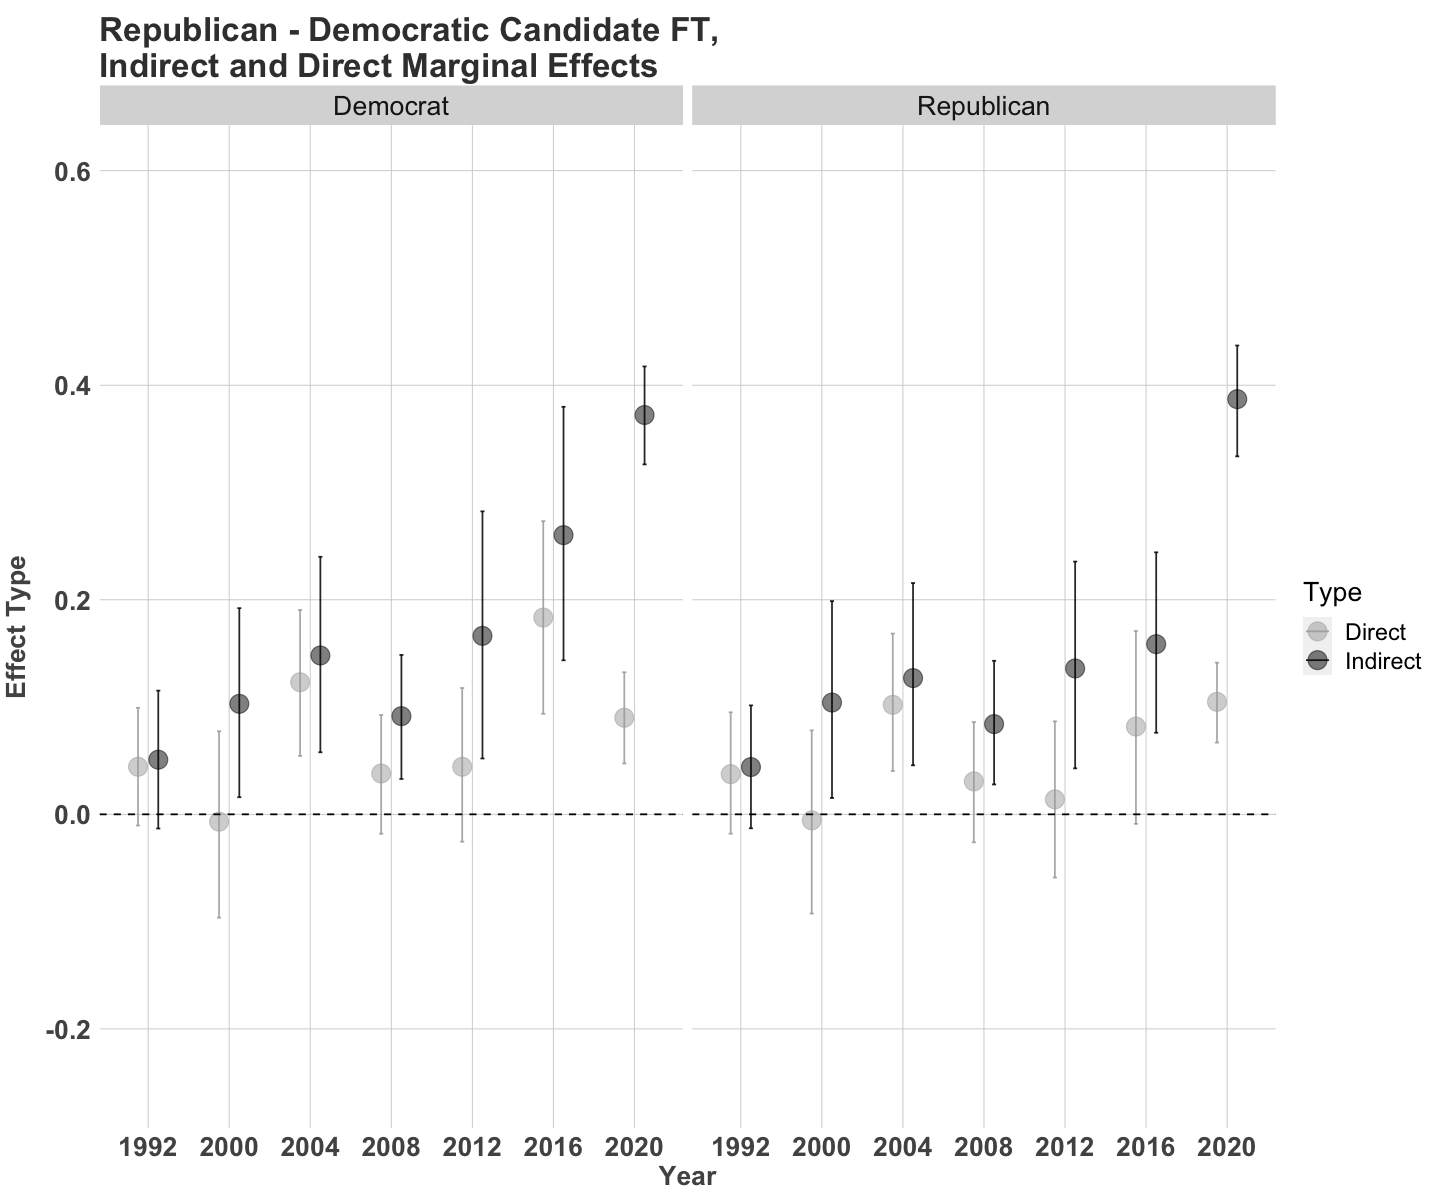

In [61]:
plt = a[[2]]
plt$type = ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party = ifelse(grepl("*_0", row.names(plt)), "Democrat", "Republican")
plt$year = rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each =4)
plt %>% ggplot(aes(x = factor(year), 
                  y = mean, ymin=X2.5., 
                  ymax=X97.5., colour = as.factor(type), group = as.factor(type)))+ facet_wrap(~party) +
  geom_point(size=5,  alpha = 0.5, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Republican - Democratic Candidate FT,\nIndirect and Direct Marginal Effects") +
  ggtheme + 
  scale_y_continuous("Effect Type", limits=c(-0.25,0.6)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="Type", values=c("darkgrey", "black"))